In [1]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import os
from PyEIS import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import csv
import glob
import statistics
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import math

#from matplotlib.pyplot import rc
#rc('text',usetex=True)
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size='16')
#rc('text.latex', preamble=r'\usepackage{sfmath}')

#set font to Arial
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']


#Put Post-Stabilization Temperature Data into a dataframe
#This file path should go to the *post-stabilization* .txt file that Quincy puts out
file_path = "./EIS_Data/APH_1_021A/22 October 2024 06-24-04 PM/Post-Stabilization Temperature Data.txt"
df = pd.read_csv(file_path)

# Define the time column title in the data file as time
Time = 'Time (Day Month Year Hours:Minutes:Seconds AM/PM)'

# Convert the 'Time' column to datetime format
df[Time] = pd.to_datetime(df[Time], format='%d %B %Y %I:%M:%S %p')
#print(df[Time])

#WAS IT DAYLIGHT SAVINGS TIME WHEN YOU COLLECTED YOUR DATA? if yes, set daylight_savings to true. If not, set to false.
daylight_savings=True

if daylight_savings==True:
    #for daylight time (mid March - mid November):
    df['EpochTime'] = ((df[Time] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')) + 21600

if daylight_savings==False:
    # for standard time (mid November - mid March):
    df['EpochTime'] = ((df[Time] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')) + 25200

# Define the target temperatures, these should be whatever temperatures you dwelled at. 
target_temperatures = [30, 35, 45, 55, 65, 75, 85, 95]
# Create a dictionary to store the first and last time for each temperature
temperature_ranges = {temp: {'first_time': None, 'last_time': None} for temp in target_temperatures}

# Iterate through the DataFrame rows
for index, row in df.iterrows():
    temperature = row['Oven Temperature (degrees C)']

    # Check if the temperature is within 0.5 degrees of any target temperature
    for target_temp in target_temperatures:
        if abs(temperature - target_temp) <= 0.5:
            if temperature_ranges[target_temp]['first_time'] is None:
                temperature_ranges[target_temp]['first_time'] = row['EpochTime']
            temperature_ranges[target_temp]['last_time'] = row['EpochTime']

# Create a DataFrame from the temperature_ranges dictionary
temperature_ranges_df = pd.DataFrame(temperature_ranges.items(), columns=['Temperature', 'TimeRange'])

# Split the 'TimeRange' column into 'Start' and 'End' columns
temperature_ranges_df[['Start', 'End']] = pd.DataFrame(temperature_ranges_df['TimeRange'].tolist(), index=temperature_ranges_df.index)

# Drop the original 'TimeRange' column
temperature_ranges_df = temperature_ranges_df.drop('TimeRange', axis=1)

# Print the resulting DataFrame
print(temperature_ranges_df)


   Temperature       Start         End
0           30  1729643804  1729647527
1           35  1729651678  1729654501
2           45  1729660282  1729663583
3           55  1729668515  1729672040
4           65  1729676053  1729679750
5           75  1729683293  1729687066
6           85  1729689777  1729693535
7           95  1729695513  1729699271


In [2]:
#INPUT DIAMETER AND HEIGHT OF PELLET HERE!
#diameter in mm
diameter = 6
#pellet height in mm
height = 2.237

#Errors in the thickness and height, generally no need to change this.
#err in pellet diameter (mm)
diameter_err=0.01
#err in pellet height (mm)
height_err=0.001

In [3]:
# Specify the folder path where '.DTA' files are located
# Note that this is the FOLDER with all your .DTA files.
folder_path = "./EIS_Data/APH_1_021A/"

#front to back it should run

folder_path = "./EIS_Data/APH_1_021A/"
file_name=folder_path+'EISPOT_#1.DTA'

daylight_savings=True
def extract_epochtime(file_path):
    # Open the file in read mode
    with open(file_path, 'r', encoding='latin-1') as file:
        # Read the entire file content
        lines = file.readlines()

        # Look for the lines containing the date and time using regex
        #This reads the resulting file string for a string LABEL + tab + 2 digits / 2 digits / 4 digits
        date_regex = re.compile(r'DATE\tLABEL\t(\d{1,2}/\d{1,2}/\d{4})\tDate')
        time_regex = re.compile(r'LABEL\t(\d{1,2}:\d{2}:\d{2})')
        date = None
        time = None

        for line in lines:
            # Check if the line matches the date pattern
            if date_regex.search(line):
                date = date_regex.search(line).group(1) #this takes the first string found
                #print(date)
            # Check if the line matches the time pattern
            if time_regex.search(line):
                time = time_regex.search(line).group(1)
                #print(time)
    #puts date and time in a single string
    date_time_str = date+'-'+time
    # Define the format in which the date and time are provided
    date_time_format = '%m/%d/%Y-%H:%M:%S'
    # Convert the string to a datetime object
    dt_object = datetime.datetime.strptime(date_time_str, date_time_format)
    # Convert the datetime object to epoch time (seconds since Jan 1, 1970)
    et = int(dt_object.timestamp()) #produces 10 digit int for epoch time
    if daylight_savings==True:
        #for daylight time (mid March - mid November):
        epoch_time = et #+ 21600
    else:
        epoch_time = et #+ 25200
        
    return epoch_time

# Function to list '.DTA' files between specified timestamps
def list_files_between_timestamps(folder_path, start_timestamp, end_timestamp):

    file_list = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a '.DTA' file
        if filename.endswith('.DTA') and os.path.isfile(file_path):
            # Get the file's last modification timestamp
            file_timestamp = extract_epochtime(file_path)
            #print(start_timestamp, end_timestamp, file_timestamp)
            if start_timestamp <= file_timestamp <= end_timestamp:
                file_list.append(filename)

    return file_list


In [4]:
# Use loc to filter rows based on the temperature value
#start_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['Start']]
#end_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['End']]

# Print the result
#print(start_result)

files_found_dict = {}

#Iterate through target temperatures
for search_temp in target_temperatures:
    start_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['Start']]
    end_result = temperature_ranges_df.loc[temperature_ranges_df['Temperature'] == search_temp, ['End']]
        # Assuming start_result and end_result are datetime objects
    start_time = start_result.iloc[0]['Start']
    end_time = end_result.iloc[0]['End']
    # Print intermediate results for troubleshooting
    #print(f"Search Temperature: {search_temp}")
    #print("Start Time:")
    #print(start_time)
    #print("End Time:")
    #print(end_time)
    #YEET the files from between the start and end times into a dictionary
    files_found_dict[search_temp] = list_files_between_timestamps(folder_path, start_time, end_time)
    #print(files_found_dict)
# Print the results
    
print(files_found_dict[30])
    # Print the results for each temperature
    #print(f"Results for Temperature {search_temp}:")
    #print("Start:", start_result.iloc[0]['Start'] if not start_result.empty else "Not found")
    #print("End:", end_result.iloc[0]['End'] if not end_result.empty else "Not found")
    #print()


['EISPOT_#4.DTA', 'EISPOT_#5.DTA', 'EISPOT_#6.DTA', 'EISPOT_#7.DTA', 'EISPOT_#8.DTA', 'EISPOT_#9.DTA']


In [5]:
# Function to extract the numerical part from the filename
def extract_number(filename):
    match = re.search(r'#(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

# Common parameters for all files

#The values here are the highest frequency and lowest frequency that are included. 
common_params = {
    'mask': [10**7, 100]}

# Dictionary to store the EIS_exp instances
all_experiments = {}

# Iterate through the keys in files_found_dict
for temp, file_list in files_found_dict.items():
    temp_experiments = {}
    file_list.sort(key=extract_number) #sort the .DTA files in order
    # Iterate through the file list for each temperature
    for idx, filename in enumerate(file_list, start=1):
        #print(filename)
        params = {'path': folder_path, 'data': [filename]}
        params.update(common_params)
        
        
        #var_name = f"Ex{idx}_Temp{temp}"
        
        # Call the EIS_exp function and store the instance in the dictionary, dictionary has two keys
        temp_experiments[idx] = EIS_exp(**params)
    
        # Store the experiments for each temperature in the overall dictionary
        #this generates the 'all_experiments' dictionary with a two part key. The first part of the key is the temperature, while the second part of the key is the replicate at that temperature.
        all_experiments[temp,idx] = temp_experiments[idx]

# Print the resulting dictionary of experiments
#print(all_experiments)

In [9]:
#In order to fit the experimental data, a parameter space is needed for the EIS_fit() function with initial guesses
#for each parameter including lower and upper bounds.
#You may want to rerun this step until the data fits well.
#Adjusting starting parameters to match your data will give the best results

#If this section is confusing to you or you are struggling with equivalent circuit modeling, check out:
#DOI: 10.1021/acsmeasuresciau.2c00070
#DOI: 10.1002/celc.202100108

#do you want to do a sequential fit where the results of the previous fit are used as the starting values for the next one?
#This is particularly useful for temperature dependent datasets to allow for the parameter drift over different temperatures
sequentialfit='yes'
params= Parameters() #creates the parameter space
#the following guesses will need to be adjusted based on your data as well as the equivalent circuit to be fit
#the following equivalent circuit is the Rs_(RQ)1_Q circuit

#Rs_guess is the leading resistor that accounts for the resistance of our leads and equipment
#This is generally 0 or close to 0 for Austin's samples. 
#If your whole semicircle is visible, a good starting value is where the left hand side of the semicircle touches down on the z-real axis
Rs_guess = 0
params.add('Rs', value=Rs_guess, min=0, max=1)

#R1_guess is the bulk resistance that is in the RQ element
#A good starting guess is where the right side of your semicircle comes closest to the z-real axis.
R1_guess = 52000
params.add('R1', value=R1_guess, min=0, max=10**10)

#n1_guess represents the ideality of your semicircle
#if it's squashed, use a lower starting value, if it's gorgeous, use a value closer to 1
n1_guess = 0.7
params.add('n1', value=n1_guess, min=0.6, max=1) #do not change min max values of n otherwise they become meaningless

#fs1_guess represents the characteristic frequency for the semicircle
#this is the frequency corresponding to the maximum z-imaginary value for your semicircle
fs1_guess = 9000000
params.add('fs1', value=fs1_guess, min=fs1_guess*.001, max=fs1_guess*100)

#n_guess and Q-guess represent the ideality of the capacitor-like behavior of the capacitive tail
n_guess = 0.7
params.add('n', value=n1_guess, min=0.6, max=1) #do not change min max values of n otherwise they become meaningless
Q_guess = 10**-7
params.add('Q', value=Q_guess, min=Q_guess*0.001, max=Q_guess*1000)

#code below actually does the fit, change the circuit to what you need with circuit = ''
#experiments['Ex1'].EIS_fit(params=params, circuit='R-RQ-Q')
# Dictionary to store fit results
fit_results = {}

# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in all_experiments.items():
    temp_fit_results = {}

    # Iterate through the inner dictionary (individual experiments for each temperature)
    #for exp_name, exp_instance in temp_experiments.items():
    fit_result = exp_instance.EIS_fit(params=params, circuit='R-RQ-Q')
    temp_fit_results[key] = fit_result
    print(f'Start R1 value for temp {key[0]}C, replicate {key[1]}:', params['R1'].value)
    print(f'Refined R1 value for temp {key[0]}C, replicate {key[1]}:', exp_instance.fit_R1[0])
    if sequentialfit == 'yes':
        params['Rs'].value = exp_instance.fit_Rs[0]
        params['R1'].value = exp_instance.fit_R1[0]
        params['n1'].value = exp_instance.fit_n1[0]
        params['fs1'].value = exp_instance.fit_fs1[0]
        params['n'].value = exp_instance.fit_n[0]
        params['Q'].value = exp_instance.fit_Q[0]
    # Store the fit results for each temperature
    fit_results[key] = temp_fit_results

# Print the overall fit results
print(fit_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 172
    # data points      = 86
    # variables        = 6
    chi-square         = 2770805.48
    reduced chi-square = 34635.0685
    Akaike info crit   = 904.705914
    Bayesian info crit = 919.431998
[[Variables]]
    Rs:   0.00351959 +/- 8499488.67 (241491169731.06%) (init = 0)
    R1:   49465.1260 +/- 2109.01073 (4.26%) (init = 52000)
    n1:   0.91831595 +/- 0.03330832 (3.63%) (init = 0.7)
    fs1:  834035.788 +/- 34228.0836 (4.10%) (init = 9000000)
    n:    0.76262851 +/- 0.02839547 (3.72%) (init = 0.7)
    Q:    1.5290e-07 +/- 3.1550e-08 (20.63%) (init = 1e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9796
    C(R1, n1)  = -0.9444
    C(Rs, R1)  = -0.9334
    C(Rs, n1)  = +0.8854
    C(R1, n)   = +0.6085
    C(n1, n)   = -0.5671
    C(R1, Q)   = -0.5518
    C(n1, Q)   = +0.5137
    C(Rs, n)   = -0.4417
    C(Rs, fs1) = -0.4187
    C(Rs, Q)   = +0.3997
    C(fs1, n)  =

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12093
    # data points      = 86
    # variables        = 6
    chi-square         = 186976.821
    reduced chi-square = 2337.21027
    Akaike info crit   = 672.857767
    Bayesian info crit = 687.583851
[[Variables]]
    Rs:   0.08814217 +/- 633.807374 (719073.92%) (init = 0.1495573)
    R1:   35582.0466 +/- 761.195862 (2.14%) (init = 36642.93)
    n1:   0.96223363 +/- 0.01559877 (1.62%) (init = 0.9628718)
    fs1:  1171506.44 +/- 26565.0764 (2.27%) (init = 1149201)
    n:    0.80907577 +/- 0.01940772 (2.40%) (init = 0.8336693)
    Q:    1.3212e-07 +/- 1.7861e-08 (13.52%) (init = 1.117492e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9839
    C(Rs, R1)  = +0.9631
    C(R1, n1)  = -0.9067
    C(Rs, n1)  = -0.8563
    C(Rs, fs1) = +0.7894
    C(R1, fs1) = +0.6832
    C(n1, fs1) = -0.6635
    C(n1, n)   = -0.1736
    C(fs1, n)  = -0.1690
    C(n1, Q)   = +0.1654
    C(fs1, Q)  

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 86
    # variables        = 6
    chi-square         = 22743.5509
    reduced chi-square = 284.294386
    Akaike info crit   = 491.681306
    Bayesian info crit = 506.407390
[[Variables]]
    Rs:   0.75543647 +/- 259.192097 (34310.24%) (init = 0.9272759)
    R1:   18910.0956 +/- 309.517442 (1.64%) (init = 19025.13)
    n1:   0.97990803 +/- 0.01295998 (1.32%) (init = 0.9785415)
    fs1:  2078243.84 +/- 58244.4631 (2.80%) (init = 2056385)
    n:    0.76679337 +/- 0.01231782 (1.61%) (init = 0.7658621)
    Q:    2.5470e-07 +/- 2.4076e-08 (9.45%) (init = 2.524167e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9629
    C(Rs, R1)  = -0.9460
    C(R1, n1)  = -0.7495
    C(Rs, fs1) = -0.6312
    C(Rs, n1)  = +0.6082
    C(R1, fs1) = +0.5736
    C(n1, fs1) = -0.5393
    C(n1, n)   = -0.2953
    C(R1, n)   = +0.2613
    C(n1, Q)   = +0.2384
    C(R1, Q)   = -0.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 86
    # variables        = 6
    chi-square         = 339.228962
    reduced chi-square = 4.24036202
    Akaike info crit   = 130.020207
    Bayesian info crit = 144.746291
[[Variables]]
    Rs:   0.97163101 +/- 76.1426283 (7836.58%) (init = 0.9998605)
    R1:   11289.1659 +/- 33.8178454 (0.30%) (init = 11383.22)
    n1:   0.97373975 +/- 0.00491901 (0.51%) (init = 0.983118)
    fs1:  3257062.57 +/- 26682.6642 (0.82%) (init = 3407740)
    n:    0.74163145 +/- 0.00408370 (0.55%) (init = 0.752107)
    Q:    4.9847e-07 +/- 1.4418e-08 (2.89%) (init = 4.567136e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9738
    C(Rs, R1)  = +0.6852
    C(R1, n1)  = -0.5269
    C(Rs, n)   = -0.4971
    C(Rs, Q)   = +0.4534
    C(Rs, fs1) = +0.4529
    C(R1, fs1) = +0.3206
    C(n1, fs1) = -0.2896
    C(fs1, n)  = -0.2282
    C(fs1, Q)  = +0.2084
    C(n1, n)   = -0.19

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 192
    # data points      = 86
    # variables        = 6
    chi-square         = 7.14430863
    reduced chi-square = 0.08930386
    Akaike info crit   = -201.970688
    Bayesian info crit = -187.244604
[[Variables]]
    Rs:   0.02506498 +/- 5.41481578 (21603.12%) (init = 0.993185)
    R1:   5023.56178 +/- 2.33681712 (0.05%) (init = 7202.11)
    n1:   0.94085653 +/- 0.00665870 (0.71%) (init = 0.9501873)
    fs1:  7656263.04 +/- 102207.387 (1.33%) (init = 5285569)
    n:    0.74030414 +/- 0.00287619 (0.39%) (init = 0.7319455)
    Q:    1.6404e-06 +/- 3.9906e-08 (2.43%) (init = 1.04444e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9656
    C(n1, fs1) = -0.6372
    C(Rs, n)   = +0.6296
    C(Rs, Q)   = -0.5103
    C(Rs, n1)  = -0.5022
    C(Rs, R1)  = -0.4414
    C(n1, n)   = -0.3242
    C(n1, Q)   = +0.2558
    C(R1, n)   = -0.2378
    C(R1, Q)   = +0.2079
    C(Rs, fs1) = +0.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 86
    # variables        = 6
    chi-square         = 0.50757777
    reduced chi-square = 0.00634472
    Akaike info crit   = -429.390927
    Bayesian info crit = -414.664843
[[Variables]]
    Rs:   0.00139215 +/- 2.38791720 (171527.79%) (init = 0.001102763)
    R1:   3234.48214 +/- 0.53506758 (0.02%) (init = 3305.215)
    n1:   0.92855519 +/- 0.00554256 (0.60%) (init = 0.9265162)
    fs1:  12844389.3 +/- 192123.062 (1.50%) (init = 1.282087e+07)
    n:    0.76399451 +/- 0.00316780 (0.41%) (init = 0.7616807)
    Q:    2.7407e-06 +/- 7.0473e-08 (2.57%) (init = 2.680274e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9685
    C(n1, fs1) = -0.7887
    C(Rs, n)   = +0.6810
    C(Rs, n1)  = -0.6740
    C(Rs, Q)   = -0.5850
    C(Rs, R1)  = -0.5148
    C(R1, n)   = -0.4492
    C(n1, n)   = -0.4309
    C(R1, Q)   = +0.3889
    C(Rs, fs1) = +0.3801
    C(n1,

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 110
    # data points      = 86
    # variables        = 6
    chi-square         = 343.673610
    reduced chi-square = 4.29592012
    Akaike info crit   = 131.139679
    Bayesian info crit = 145.865763
[[Variables]]
    Rs:   0.98449709 +/- 22.5361216 (2289.10%) (init = 0.1944189)
    R1:   2145.45172 +/- 15.6049942 (0.73%) (init = 2166.59)
    n1:   0.99936865 +/- 0.11089161 (11.10%) (init = 0.907636)
    fs1:  22964872.9 +/- 8336841.76 (36.30%) (init = 2.41349e+07)
    n:    0.78827349 +/- 0.02444868 (3.10%) (init = 0.7768679)
    Q:    4.5710e-06 +/- 7.6968e-07 (16.84%) (init = 4.470846e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(n, Q)    = -0.9841
    C(Rs, R1)  = +0.9149
    C(n1, fs1) = -0.8287
    C(Rs, n1)  = +0.7864
    C(R1, n1)  = +0.6252
    C(Rs, fs1) = -0.6011
    C(R1, fs1) = -0.4696
    C(R1, n)   = +0.4509
    C(R1, Q)   = -0.4273
    C(Rs, n)   = +0.2033
    C(Rs, Q)   

<Figure size 600x600 with 0 Axes>

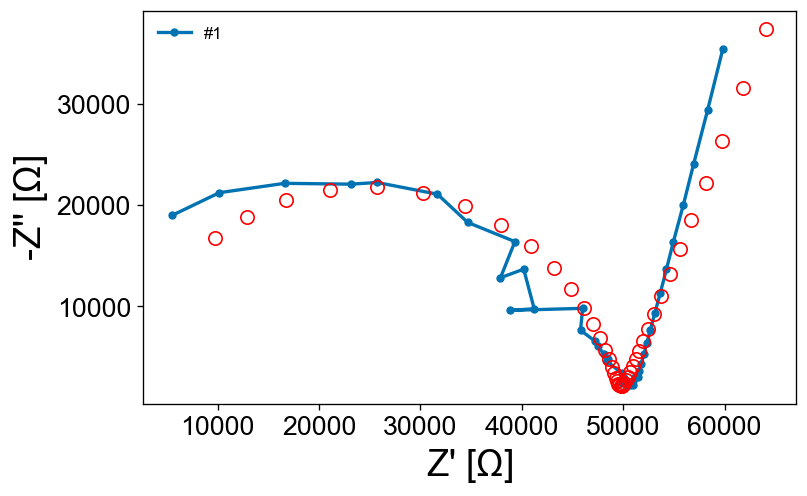

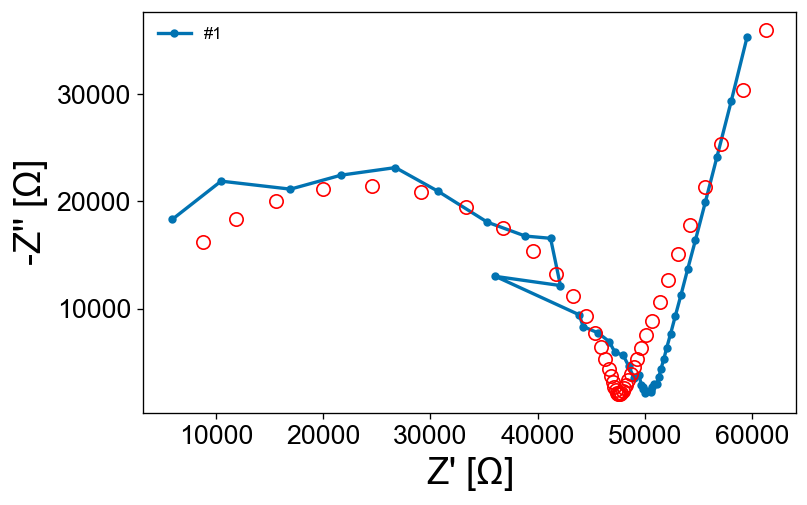

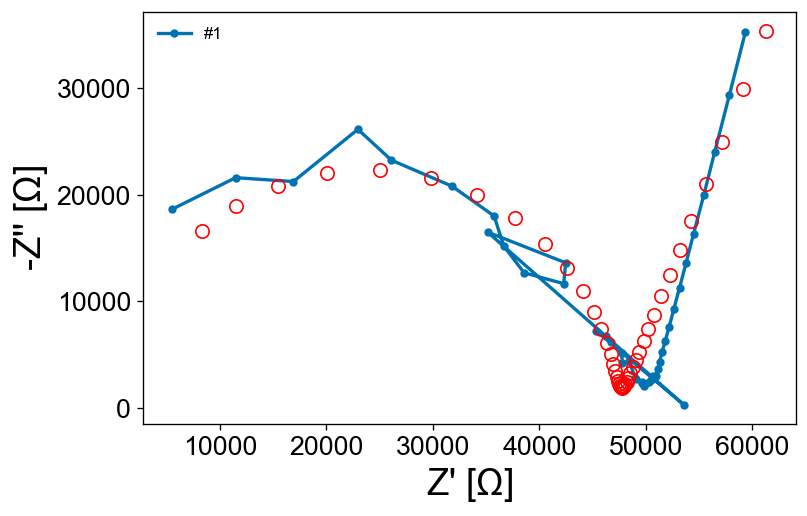

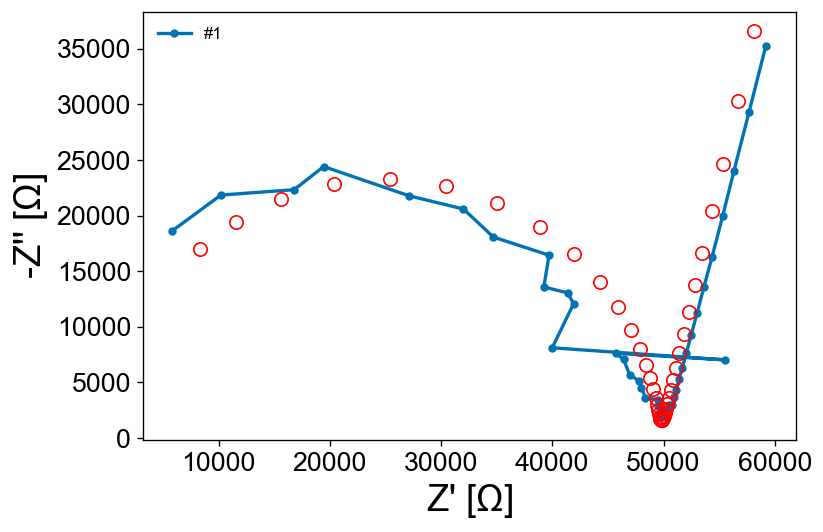

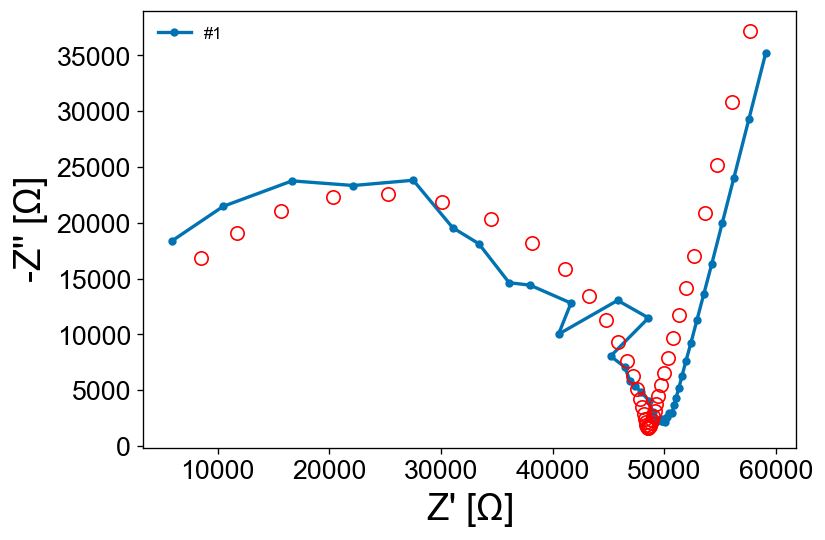

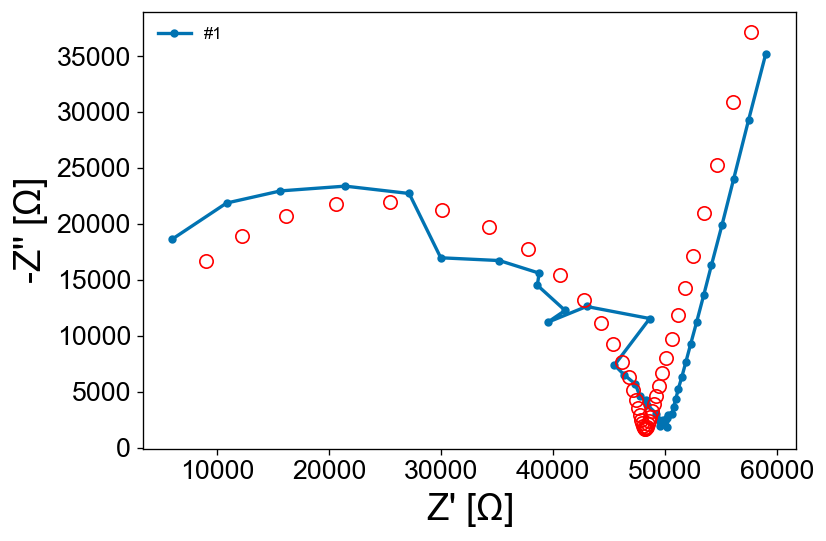

In [10]:
#plot individual data with fitting
#The below example plots all of the replicates at 30C
plt.figure(figsize=(6,6))
for key, exp_instance in all_experiments.items():
    if key[0]==30:
        all_experiments[key].EIS_plot(fitting='on')
    
#all_experiments[30]['Ex7_Temp30'].EIS_plot(fitting='on')
#xdownlim=0
#uplim=40000
#plt.ylim(0,uplim)
#plt.xlim(xdownlim,uplim)

#plt.show()

In [11]:
#Here we load in the optimized values for R1 and the characteristic frequency into discrete dictionaries

R1_opt = {}
Fs1_opt={}
# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in all_experiments.items():
    # Iterate through the inner dictionary (individual experiments for each temperature)
        R1_optm = float(exp_instance.fit_R1[0])
        R1_opt[key] = R1_optm
        Fs1_optm= float(exp_instance.fit_fs1[0])
        Fs1_opt[key]=Fs1_optm

print(R1_opt)
print(Fs1_opt)

{(30, 1): 49465.126041869924, (30, 2): 47261.85893366708, (30, 3): 47367.32736321248, (30, 4): 49688.09382388528, (30, 5): 48402.43678416734, (30, 6): 48067.231707138446, (35, 1): 36642.92855254381, (35, 2): 35582.04656195496, (35, 3): 36767.24327217329, (35, 4): 35456.34318702362, (35, 5): 37004.919226646394, (45, 1): 23352.479902039035, (45, 2): 19706.834853416844, (45, 3): 19334.26584332931, (45, 4): 19225.99522474755, (45, 5): 19025.132523275977, (45, 6): 18910.09556331813, (55, 1): 12095.871443351669, (55, 2): 11909.75168152697, (55, 3): 11673.579378146393, (55, 4): 11675.583261316902, (55, 5): 11561.715173580289, (55, 6): 11383.216541038799, (55, 7): 11289.165880445928, (65, 1): 7605.8784886923195, (65, 2): 7457.880195627098, (65, 3): 7368.610996372205, (65, 4): 7288.557446472055, (65, 5): 7227.341746740556, (65, 6): 7202.109512105537, (75, 1): 5023.561776562602, (75, 2): 4902.1235126733845, (75, 3): 4856.012076892568, (75, 4): 4814.361257432509, (75, 5): 4753.103963750505, (75, 

In [15]:
#here we make a bunch of dataframes for nyquist plots
#samplename and materialname are included in output files, so change them as appropriate
samplename='APH_1_021A'
materialname='NaAlCl4'

#in this cell, we generate simulated data for each nyquist plot so as to be able to export experimental and modeled values
#for temperature dependent nyquist plots

#generates a frequency range for any simulations
f_range = freq_gen(f_start=(2*10**6), f_stop=0.2, pts_decade=10)
print(f_range[0][:4]) #First 5 points in the freq. array
print()
print(f_range[1][:4]) #First 5 points in the angular freq. array


#This chunk of code generates a simulated dataset using the parameters from the initial modelling above
sim={}
# Iterate through the outer dictionary (temperature-wise experiments)
for exp_name, exp_instance in all_experiments.items():
    sim_temp= cir_RsRQQ(w=f_range[1], Rs=float(exp_instance.fit_Rs[0]), R1=float(exp_instance.fit_R1[0]), n1=float(exp_instance.fit_n1[0]), Q1=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0]), n=float(exp_instance.fit_n[0]), Q=float(exp_instance.fit_Q[0]))
    sim[exp_name]=sim_temp

nyquist={}
# Iterate through the outer dictionary (temperature-wise experiments)
for exp_name, exp_instance in all_experiments.items():
     # Find the minimum length among the arrays for this experiment
    min_length = min(len(exp_instance.df_raw.re), len(exp_instance.df_raw.im), len(sim[exp_name].real), len(sim[exp_name].imag),len(exp_instance.df_raw.f))
    exp_name_temp=[exp_name]*min_length
    #samplenamez=[samplename]*min_length
    #materialnamez=[materialname]*min_length
    # Truncate arrays to the minimum length
    truncated_re = exp_instance.df_raw.re[:min_length]
    truncated_im = exp_instance.df_raw.im[:min_length]
    truncated_f= exp_instance.df_raw.f[:min_length]
    truncated_fit_real = sim[exp_name].real[:min_length]
    truncated_fit_imag = -sim[exp_name].imag[:min_length]
    
    # Create DataFrame with truncated arrays
    nyquist[exp_name] = pd.DataFrame({
        'Frequency':truncated_f,
        'Z real': truncated_re,
        'Z imag': truncated_im,
        'Fit real': truncated_fit_real,
        'Fit imag': truncated_fit_imag,
        'Dataset':exp_name_temp,
        #'sample_name':samplenamez,
        #'material_name':materialnamez
    })
    print(nyquist[exp_name])

[2000000.         1583363.8318526  1253520.51200948  992389.52060058]

[12566370.61435917  9948568.36421585  7876101.66330618  6235367.25483656]
       Frequency       Z real      Z imag      Fit real      Fit imag  Dataset
0   2.000039e+06     5531.071    18987.06  9.709624e+03  1.673020e+04  (30, 1)
1   1.588711e+06    10161.080    21209.78  1.294300e+04  1.880593e+04  (30, 1)
2   1.261992e+06    16602.960    22133.79  1.684491e+04  2.049548e+04  (30, 1)
3   1.002539e+06    23164.000    22051.59  2.127229e+04  2.154324e+04  (30, 1)
4   7.962891e+05    25721.600    22219.61  2.595351e+04  2.176549e+04  (30, 1)
..           ...          ...         ...           ...           ...      ...
65  6.334459e-01   870736.300  3504476.00  1.031000e+06  2.509294e+06  (30, 1)
66  5.029507e-01  1068984.000  4257048.00  1.222399e+06  2.998607e+06  (30, 1)
67  3.999573e-01  1312176.000  5165011.00  1.451122e+06  3.583337e+06  (30, 1)
68  3.175813e-01  1613594.000  6269790.00  1.724446e+06  4.282090

       Frequency       Z real       Z imag      Fit real      Fit imag  \
0   2.000039e+06     9490.749    10379.530  9.467522e+03  8.843173e+03   
1   1.588711e+06    12276.780     9580.080  1.138887e+04  8.734086e+03   
2   1.261992e+06    14009.050     8623.264  1.319306e+04  8.278030e+03   
3   1.002539e+06    15206.270     7125.034  1.476647e+04  7.559189e+03   
4   7.962891e+05    15967.110     6210.487  1.605373e+04  6.690096e+03   
..           ...          ...          ...           ...           ...   
65  6.334459e-01   530318.900  1823314.000  6.265925e+05  1.782895e+06   
66  5.029507e-01   642448.600  2204788.000  7.497803e+05  2.144793e+06   
67  3.999573e-01   778654.800  2662362.000  8.979730e+05  2.580150e+06   
68  3.175813e-01   947840.100  3214748.000  1.076246e+06  3.103878e+06   
69  2.520161e-01  1147540.000  3890117.000  1.290706e+06  3.733914e+06   

    Dataset  
0   (45, 2)  
1   (45, 2)  
2   (45, 2)  
3   (45, 2)  
4   (45, 2)  
..      ...  
65  (45, 2)  

       Frequency      Z real       Z imag       Fit real       Fit imag  \
0   2.000039e+06    6201.822     2457.247    6110.124250    2356.829309   
1   1.588711e+06    6491.396     2002.256    6443.251306    2013.397692   
2   1.261992e+06    6724.551     1636.525    6688.112345    1691.374481   
3   1.002539e+06    6834.709     1425.082    6864.084792    1404.117568   
4   7.962891e+05    6903.272     1124.019    6988.923813    1156.426063   
..           ...         ...          ...            ...            ...   
65  6.334459e-01  154243.000   507054.600  184169.755219  399826.437478   
66  5.029507e-01  186526.200   613478.900  217293.952899  474701.578610   
67  3.999573e-01  226610.600   740882.700  256621.289648  563598.521071   
68  3.175813e-01  279705.300   894267.500  303313.421812  669143.115115   
69  2.520161e-01  341527.300  1082291.000  358749.548091  794452.951648   

    Dataset  
0   (65, 4)  
1   (65, 4)  
2   (65, 4)  
3   (65, 4)  
4   (65, 4)  
..      ...  
6

       Frequency     Z real       Z imag      Fit real       Fit imag  Dataset
0   2.000039e+06   2247.048     264.1642   2234.055869     253.222112  (95, 1)
1   1.588711e+06   2238.249     204.7746   2246.274448     203.182521  (95, 1)
2   1.261992e+06   2252.686     164.6115   2254.430149     162.867141  (95, 1)
3   1.002539e+06   2259.514     142.5060   2259.921467     130.569572  (95, 1)
4   7.962891e+05   2263.324      99.1541   2263.670747     104.811334  (95, 1)
..           ...        ...          ...           ...            ...      ...
65  6.334459e-01  27547.700   79097.9100  34644.852984   72407.028843  (95, 1)
66  5.029507e-01  31590.990   95343.9000  40684.977503   85916.296011  (95, 1)
67  3.999573e-01  36545.150  114834.4000  47852.032065  101946.040863  (95, 1)
68  3.175813e-01  41801.420  138668.5000  56356.272486  120966.518941  (95, 1)
69  2.520161e-01  48010.160  167749.9000  66447.182849  143535.723227  (95, 1)

[70 rows x 6 columns]
       Frequency     Z real  

In [16]:
#Define functions

#function to generate a list of files from the target directory
def file_dict(file_DIR):
    ext = ('*.csv')
    list_files = glob.glob(os.path.join(file_DIR, ext))
    return list_files

#function to generate a list of colors in hex format using start color, end color, and the target folder(directory) length
def color_gradient(startcolor,endcolor,temperatures):
    color_list = list(startcolor.range_to(endcolor, len(temperatures)))
    datacolor = {}
    for temp, color in zip(sorted(temperatures), color_list):
        datacolor[temp] = color.hex
    return datacolor

#This is a function whose only purpose is to extract the replicate number from the dataset name
def extract_temp_replicate(string):
    temp_match = re.search(r'temp_(\d+)_', string)
    if temp_match:
        temp_match=int(temp_match.group(1))
    else:
        return None
    replicate_match=re.search(r'replicate_(\d+)_', string)
    if replicate_match:
        replicate_match=int(replicate_match.group(1))
    else:
        return None
    return temp_match, replicate_match

#generate a marker for each temperature
def make_markers(marker_types,unique_temperatures):
    markers={}
    markers=marker_types * (len(unique_temperatures) // len(marker_types)) + marker_types[:len(unique_temperatures) % len(marker_types)]
    tempmarkers={}
    for i, temp in enumerate(sorted(unique_temperatures)):
        marker_index = i % len(markers)  # Calculate marker index based on the position of temperature
        tempmarkers[temp] = markers[marker_index]
    return tempmarkers

# Define a function to format the axis multiplier
def format_axis(value, tick_number, limit):
    if limit >= 1e9:
        value = value / 1e9
    elif limit >= 1e6:
        value = value / 1e6
    elif limit >= 3e3:
        value = value / 1e3
    return '{:.0f}'.format(value)

# Define a function to format the axis label unit
def labelprefix(limit):
    prefix = ''
    if limit >= 1e9:
        prefix = 'G'
    elif limit >= 1e6:
        prefix = 'M'
    elif limit >= 3e3:
        prefix = 'k'
    return prefix

#goes to the first csf and grabs the first entry in the material name column
def getmaterialname(filelist):
    firstdataframe=pd.read_csv(filelist[0])
    materialname=firstdataframe.at[0,'material_name']
    return materialname

#goes to the first csf and grabs the first entry in the sample name column
def getsamplename(filelist):
    firstdataframe=pd.read_csv(filelist[0])
    samplename=firstdataframe.at[0,'sample_name']
    return samplename

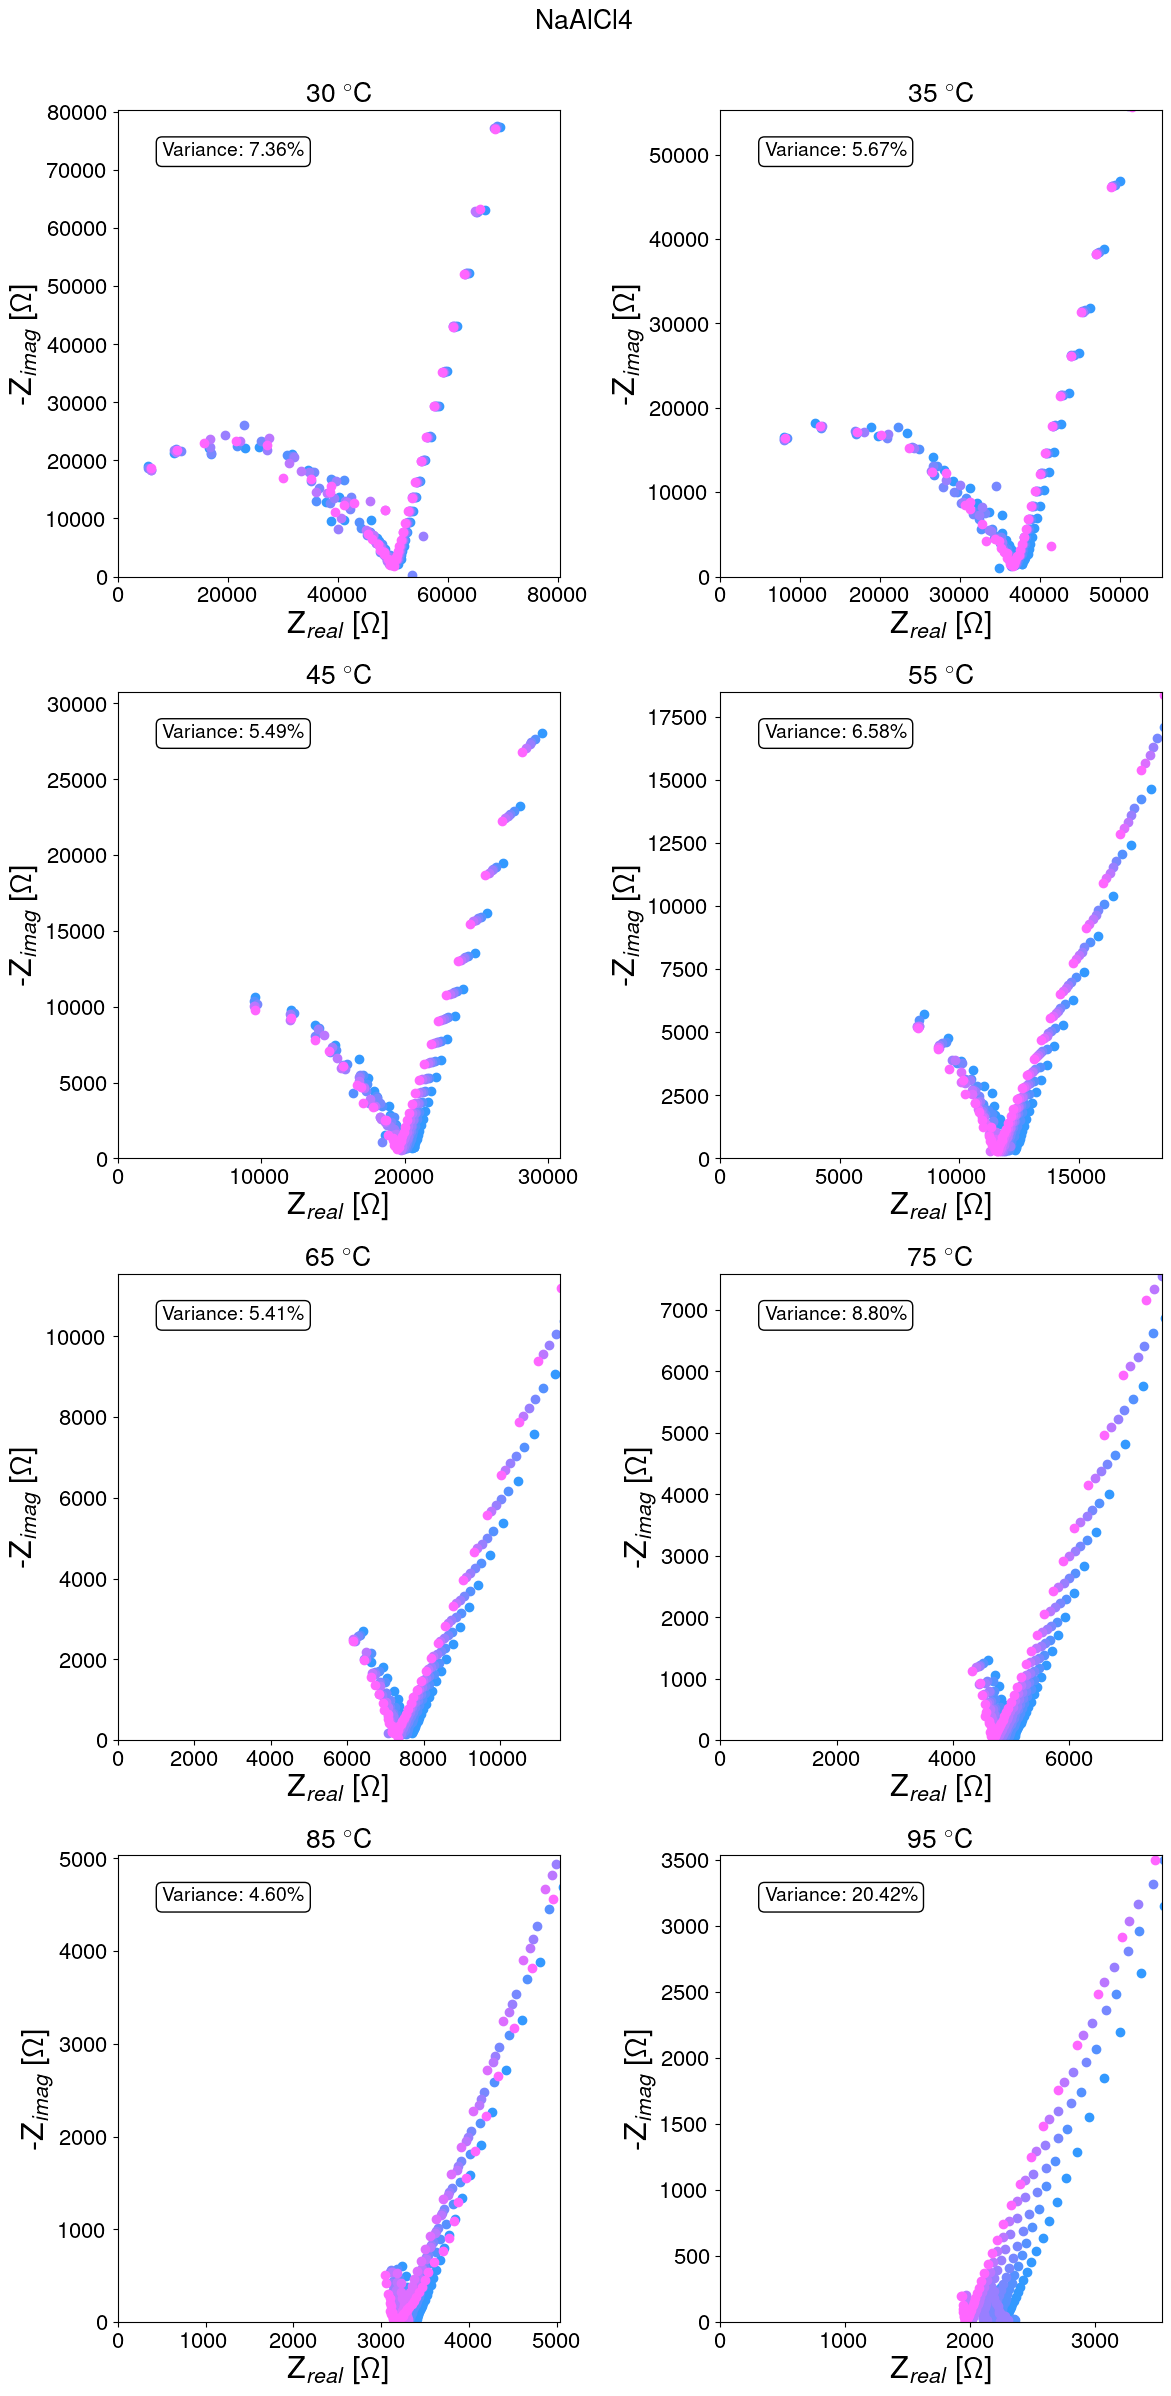

In [17]:
#This cell generates temperature dependent nyquist plots and tracks the variance between the maximum and minimum R1 values
#This is so you can see whether there is systematic drift due to equilibriation

from collections import defaultdict
import math
import matplotlib.colors as mcolors
from matplotlib.pyplot import rc

rc('text',usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']},size='16')
rc('text.latex', preamble=r'\usepackage{sfmath}')
# Create a colormap

cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#3399ff", "#ff66ff"])

# Normalize the key[1] values
all_keys = [key[1] for key in nyquist.keys()]
norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

# Group the DataFrames by the first element of their keys
grouped_nyquist = defaultdict(list)
for key, df in nyquist.items():
    grouped_nyquist[key[0]].append((key, df))

# Sort dataframes in each group by key[1]
for group_key in grouped_nyquist:
    grouped_nyquist[group_key].sort(key=lambda x: x[0][1])

# Create subplots in a 2-column layout
num_plots = len(grouped_nyquist)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
figsize = (12, 6 * num_rows)
fig0, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

# Store variance results
variance_results = {}

# Loop through each group and plot
for ax, (group_key, dataframes) in zip(axes, grouped_nyquist.items()):
    z_real_at_min_z_imag = {}
    
    for i, (key, df) in enumerate(dataframes):
        if i == len(dataframes) - 1:
            color = "#ff66ff"
        else:
            color = cmap(norm(key[1]))
        ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color)
        
        # Find index of minimum value in 'Z imag'
        min_index = df['Z imag'].idxmin()
        z_real_at_min_z_imag[key] = df.loc[min_index, 'Z real']
    
    # Calculate percent variance
    var = ((max(z_real_at_min_z_imag.values()) - min(z_real_at_min_z_imag.values())) / min(z_real_at_min_z_imag.values()))*100
    variance_results[group_key] = var
    
    # Annotate variance on plot
    ax.annotate(f'Variance: {var:.2f}\%', xy=(0.1, 0.9), xycoords='axes fraction', ha='left', fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Set limits for each subplot
    max_value = max(z_real_at_min_z_imag.values())
    limit = max_value * 1.5
    ax.set(xlim=(0, limit), ylim=(0, limit))
    ax.set_xlabel('Z$_{real}$ [$\Omega$]')
    ax.set_ylabel('-Z$_{imag}$ [$\Omega$]')
    ax.set_title(f'{group_key} $^\circ$C')

# Hide any unused axes
for i in range(len(grouped_nyquist), len(axes)):
    fig0.delaxes(axes[i])

fig0.suptitle(materialname, y=1)
plt.tight_layout()
plt.show()

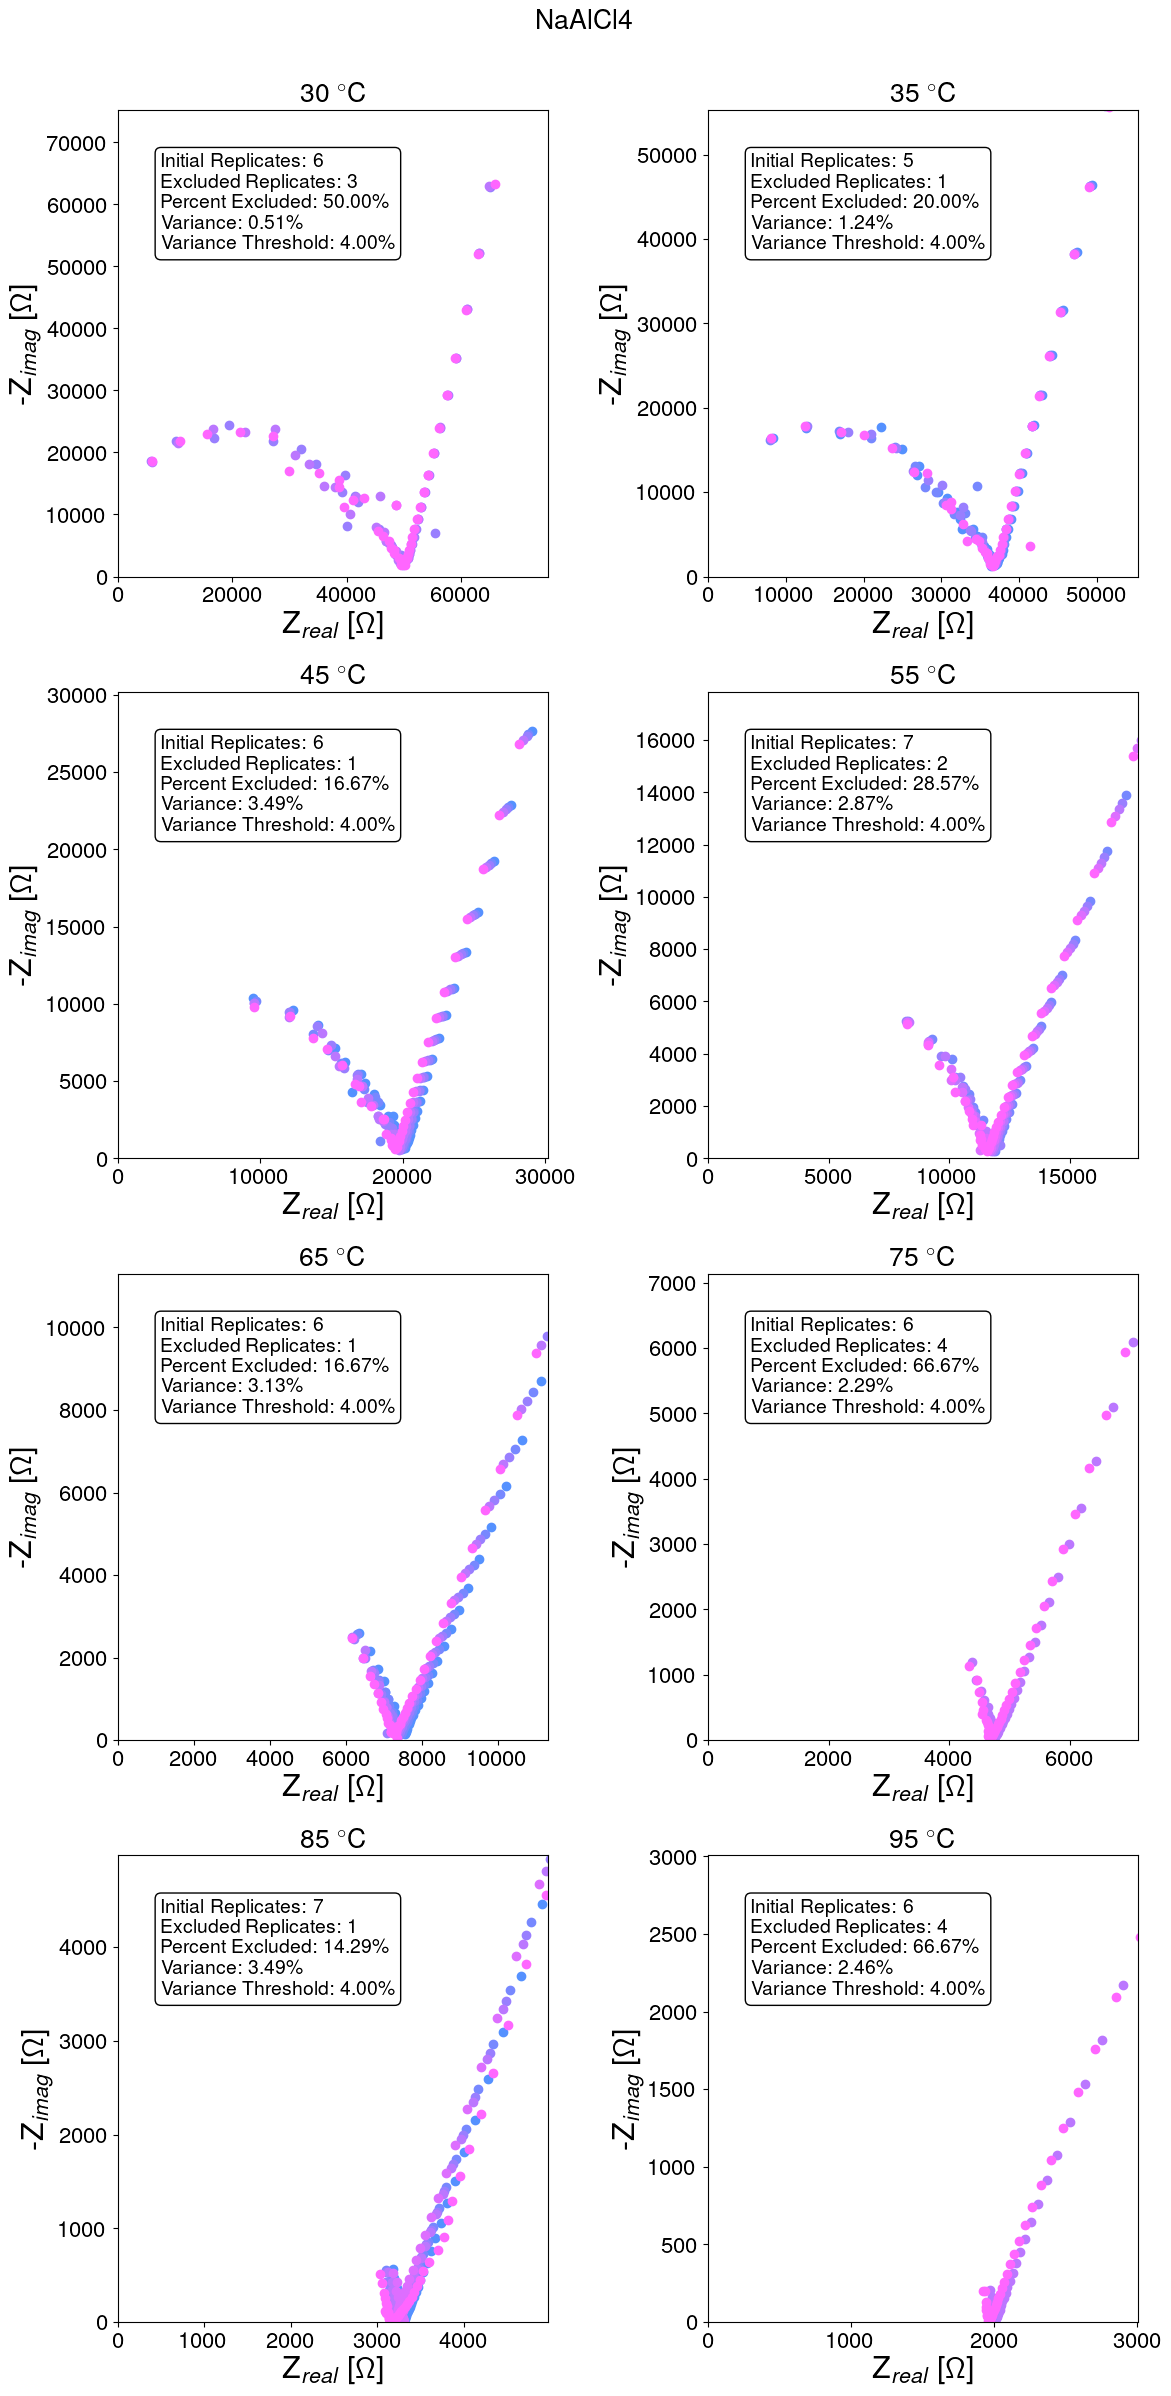

In [20]:
#This cell yeets out datasets starting at the first one collected until the variance falls below a user defined value

from collections import defaultdict
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define `nyquist`, `R1_opt`, `Fs1_opt`, `all_experiments`, and `variance_results` (sample structure)

variance_results = {}
filtered_nyquist = {}
filtered_R1_opt = {}
filtered_Fs1_opt = {}
filtered_all_experiments = {}

# Check if variables are dictionaries
if not isinstance(nyquist, dict):
    raise TypeError("nyquist must be a dictionary")
if not isinstance(R1_opt, dict):
    raise TypeError("R1_opt must be a dictionary")
if not isinstance(Fs1_opt, dict):
    raise TypeError("Fs1_opt must be a dictionary")
if not isinstance(all_experiments, dict):
    raise TypeError("all_experiments must be a dictionary")

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#3399ff", "#ff66ff"])

# Normalize the key[1] values if nyquist is not empty
if nyquist:
    all_keys = [key[1] for key in nyquist.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

# Group the DataFrames by the first element of their keys
grouped_nyquist = defaultdict(list)
for key, df in nyquist.items():
    grouped_nyquist[key[0]].append((key, df))

# Sort dataframes in each group by key[1]
for group_key in grouped_nyquist:
    grouped_nyquist[group_key].sort(key=lambda x: x[0][1])

# Create subplots in a 2-column layout
num_plots = len(grouped_nyquist)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
figsize = (12, 6 * num_rows)
fig0, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

# Function to calculate variance
def calculate_variance(z_real_values):
    return ((max(z_real_values) - min(z_real_values)) / min(z_real_values)) * 100

# User-defined variance threshold
#Change this value as needed
variance_threshold = 4  # Example threshold, modify as needed

# Loop through each group and plot
for ax, (group_key, dataframes) in zip(axes, grouped_nyquist.items()):
    z_real_at_min_z_imag = {}
    filtered_dataframes = dataframes[:]
    original_count = len(dataframes)
    
    # Filter dataframes until variance is below threshold
    while True:
        for i, (key, df) in enumerate(filtered_dataframes):
            # Find index of minimum value in 'Z imag'
            min_index = df['Z imag'].idxmin()
            z_real_at_min_z_imag[key] = df.loc[min_index, 'Z real']
        
        # Calculate percent variance
        var = calculate_variance(list(z_real_at_min_z_imag.values()))
        
        # Break the loop if variance is below threshold or only one dataframe is left
        if var <= variance_threshold or len(filtered_dataframes) == 1:
            break
        
        # Remove the dataframe with the lowest key[1]
        filtered_dataframes.pop(0)
        z_real_at_min_z_imag.clear()
    
    # Store variance results
    variance_results[group_key] = var
    
    # Store filtered nyquist datasets
    for key, df in filtered_dataframes:
        filtered_nyquist[key] = df
    
    # Filter other datasets based on the keys of filtered nyquist datasets
    filtered_keys = set(filtered_nyquist.keys())
    try:
        filtered_R1_opt = {key: value for key, value in R1_opt.items() if key in filtered_keys}
        filtered_Fs1_opt = {key: value for key, value in Fs1_opt.items() if key in filtered_keys}
        filtered_all_experiments = {key: value for key, value in all_experiments.items() if key in filtered_keys}
    except AttributeError as e:
        print(f"Error while filtering: {e}")
        print(f"R1_opt type: {type(R1_opt)}")
        print(f"Fs1_opt type: {type(Fs1_opt)}")
        print(f"all_experiments type: {type(all_experiments)}")
        raise

    # Plot the filtered dataframes
    for i, (key, df) in enumerate(filtered_dataframes):
        color = cmap(norm(key[1])) if i < len(filtered_dataframes) - 1 else "#ff66ff"
        ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color)
    
    # Annotate variance, initial count, and exclusion count on plot
    num_excluded = original_count - len(filtered_dataframes)
    ax.annotate(f'Initial Replicates: {original_count}\nExcluded Replicates: {num_excluded}\nPercent Excluded: {(num_excluded/original_count)*100:.2f}\%\nVariance: {var:.2f}\%\nVariance Threshold: {variance_threshold:.2f}\%', 
                xy=(0.1, 0.7), xycoords='axes fraction', ha='left', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Set limits for each subplot
    if z_real_at_min_z_imag:
        max_value = max(z_real_at_min_z_imag.values())
        limit = max_value * 1.5
        ax.set(xlim=(0, limit), ylim=(0, limit))
        ax.set_xlabel(f'Z$_{{real}}$ [$\Omega$]')
        ax.set_ylabel(f'-Z$_{{imag}}$ [$\Omega$]')
    ax.set_title(f'{group_key} $^\circ$C')

# Hide any unused axes
for i in range(len(grouped_nyquist), len(axes)):
    fig0.delaxes(axes[i])

fig0.suptitle(materialname, y=1)
plt.tight_layout()
plt.show()


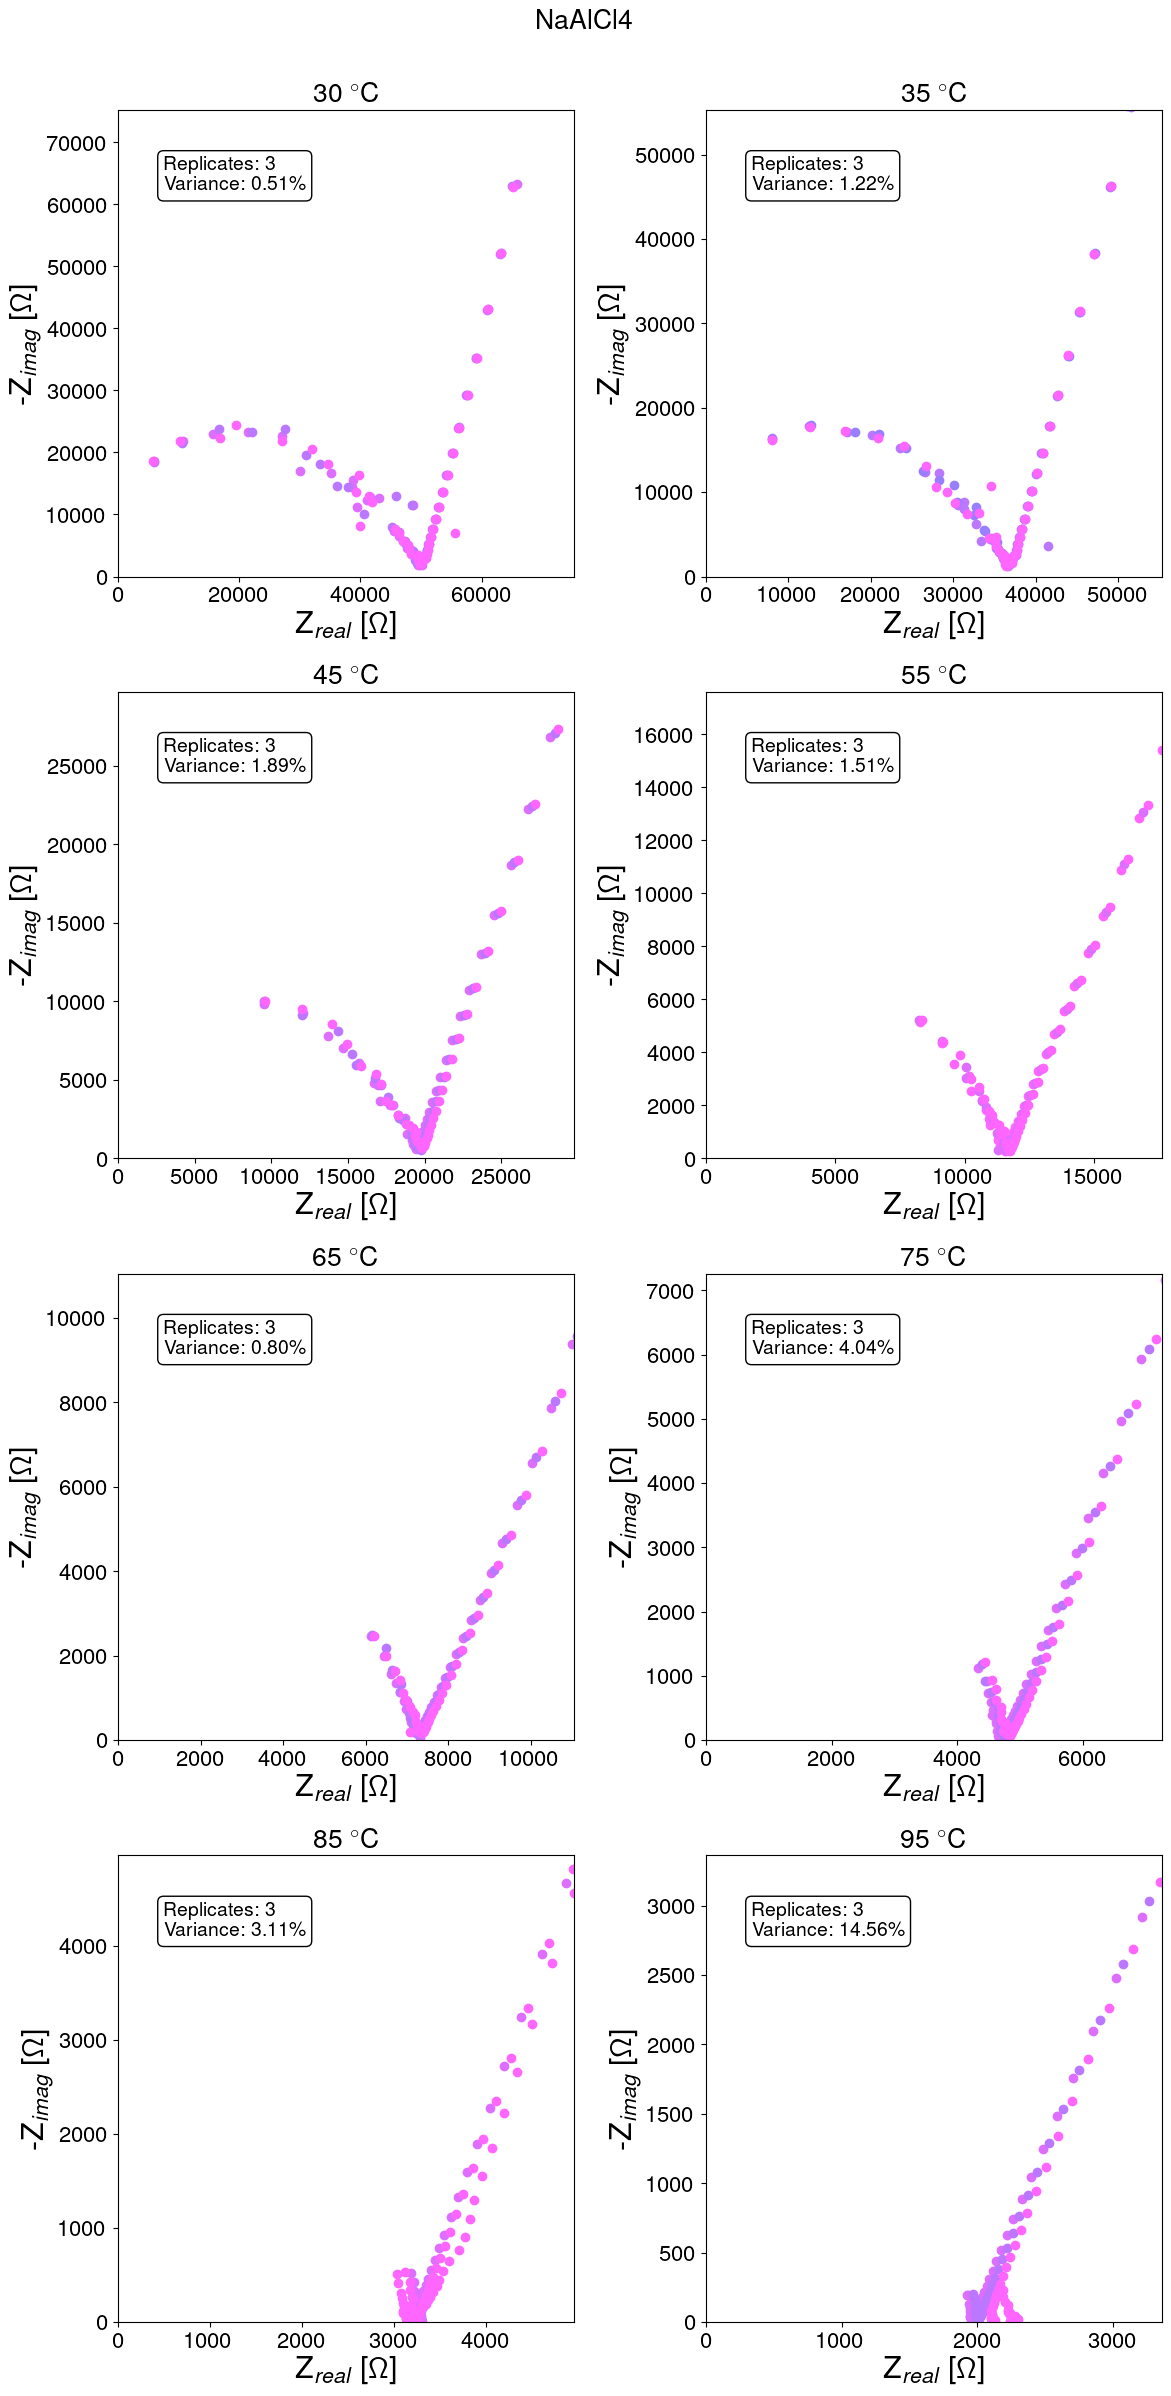

In [19]:
#This cell eliminates all but the last three datasets at each temperature and reports the variance.

from collections import defaultdict
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define `nyquist`, `R1_opt`, `Fs1_opt`, `all_experiments`, and `variance_results` (sample structure)

variance_results = {}
truncated_nyquist = {}
truncated_R1_opt = {}
truncated_Fs1_opt = {}
truncated_all_experiments = {}

# Check if variables are dictionaries
if not isinstance(nyquist, dict):
    raise TypeError("nyquist must be a dictionary")
if not isinstance(R1_opt, dict):
    raise TypeError("R1_opt must be a dictionary")
if not isinstance(Fs1_opt, dict):
    raise TypeError("Fs1_opt must be a dictionary")
if not isinstance(all_experiments, dict):
    raise TypeError("all_experiments must be a dictionary")

# Create a colormap
cmap = mcolors.LinearSegmentedColormap.from_list("gradient", ["#3399ff", "#ff66ff"])

# Normalize the key[1] values if nyquist is not empty
if nyquist:
    all_keys = [key[1] for key in nyquist.keys()]
    norm = mcolors.Normalize(vmin=min(all_keys), vmax=max(all_keys))

# Group the DataFrames by the first element of their keys
grouped_nyquist = defaultdict(list)
for key, df in nyquist.items():
    grouped_nyquist[key[0]].append((key, df))

# Keep only the last three data sets for each group
for group_key in grouped_nyquist:
    grouped_nyquist[group_key].sort(key=lambda x: x[0][1], reverse=True)
    grouped_nyquist[group_key] = grouped_nyquist[group_key][:3]

# Create subplots in a 2-column layout
num_plots = len(grouped_nyquist)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)
figsize = (12, 6 * num_rows)
fig0, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

# Function to calculate variance
def calculate_variance(z_real_values):
    return ((max(z_real_values) - min(z_real_values)) / min(z_real_values)) * 100

# Loop through each group and plot
for ax, (group_key, dataframes) in zip(axes, grouped_nyquist.items()):
    z_real_at_min_z_imag = {}
    truncated_dataframes = dataframes[:]
    original_count = len(dataframes)
    
    # Calculate variance
    for i, (key, df) in enumerate(truncated_dataframes):
        # Find index of minimum value in 'Z imag'
        min_index = df['Z imag'].idxmin()
        z_real_at_min_z_imag[key] = df.loc[min_index, 'Z real']
    
    # Calculate percent variance
    var = calculate_variance(list(z_real_at_min_z_imag.values()))
    
    # Store variance results
    variance_results[group_key] = var
    
    # Store truncated nyquist datasets
    for key, df in truncated_dataframes:
        truncated_nyquist[key] = df
    
    # Filter other datasets based on the keys of truncated nyquist datasets
    truncated_keys = set(truncated_nyquist.keys())
    try:
        truncated_R1_opt = {key: value for key, value in R1_opt.items() if key in truncated_keys}
        truncated_Fs1_opt = {key: value for key, value in Fs1_opt.items() if key in truncated_keys}
        truncated_all_experiments = {key: value for key, value in all_experiments.items() if key in truncated_keys}
    except AttributeError as e:
        print(f"Error while filtering: {e}")
        print(f"R1_opt type: {type(R1_opt)}")
        print(f"Fs1_opt type: {type(Fs1_opt)}")
        print(f"all_experiments type: {type(all_experiments)}")
        raise

    # Plot the truncated dataframes
    for i, (key, df) in enumerate(truncated_dataframes):
        color = cmap(norm(key[1])) if i < len(truncated_dataframes) - 1 else "#ff66ff"
        ax.plot(df['Z real'], df['Z imag'], linestyle='none', marker='o', color=color)
    
    # Annotate variance, initial count, and exclusion count on plot
    num_excluded = original_count - len(truncated_dataframes)
    ax.annotate(f'Replicates: {original_count}\nVariance: {var:.2f}\%', 
                xy=(0.1, 0.9), xycoords='axes fraction', ha='left',va='top', fontsize=14, 
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    
    # Set limits for each subplot
    if z_real_at_min_z_imag:
        max_value = max(z_real_at_min_z_imag.values())
        limit = max_value * 1.5
        ax.set(xlim=(0, limit), ylim=(0, limit))
        ax.set_xlabel(f'Z$_{{real}}$ [$\Omega$]')
        ax.set_ylabel(f'-Z$_{{imag}}$ [$\Omega$]')
    ax.set_title(f'{group_key} $^\circ$C')

# Hide any unused axes
for i in range(len(grouped_nyquist), len(axes)):
    fig0.delaxes(axes[i])

fig0.suptitle(materialname, y=1)
plt.tight_layout()
plt.show()


In [21]:
#set usefilteredvalues to true if you want to use the data that was filtered to satisfy the variance threshold.

usefilteredvalues=True

if usefilteredvalues==True:
    nyquist=filtered_nyquist
    R1_opt=filtered_R1_opt
    Fs1_opt=filtered_Fs1_opt
    all_experiments=filtered_all_experiments
print(R1_opt)

{(30, 4): 49688.09382388528, (30, 5): 48402.43678416734, (30, 6): 48067.231707138446, (35, 2): 35582.04656195496, (35, 3): 36767.24327217329, (35, 4): 35456.34318702362, (35, 5): 37004.919226646394, (45, 2): 19706.834853416844, (45, 3): 19334.26584332931, (45, 4): 19225.99522474755, (45, 5): 19025.132523275977, (45, 6): 18910.09556331813, (55, 3): 11673.579378146393, (55, 4): 11675.583261316902, (55, 5): 11561.715173580289, (55, 6): 11383.216541038799, (55, 7): 11289.165880445928, (65, 2): 7457.880195627098, (65, 3): 7368.610996372205, (65, 4): 7288.557446472055, (65, 5): 7227.341746740556, (65, 6): 7202.109512105537, (75, 5): 4753.103963750505, (75, 6): 4690.199450485544, (85, 2): 3305.214608673168, (85, 3): 3234.4821393470725, (85, 4): 3221.2705963763356, (85, 5): 3217.6619896295833, (85, 6): 3218.082246236875, (85, 7): 3173.6223049527725, (95, 5): 2001.1342288794865, (95, 6): 1963.2819636683507}


In [22]:
#set usetruncatedvalues to true if you want to use the last 3 datasets at each temperature

usetruncatedvalues=False

if usetruncatedvalues==True:
    nyquist=truncated_nyquist
    R1_opt=truncated_R1_opt
    Fs1_opt=truncated_Fs1_opt
    all_experiments=truncated_all_experiments
print(R1_opt)

{(30, 4): 49688.09382388528, (30, 5): 48402.43678416734, (30, 6): 48067.231707138446, (35, 2): 35582.04656195496, (35, 3): 36767.24327217329, (35, 4): 35456.34318702362, (35, 5): 37004.919226646394, (45, 2): 19706.834853416844, (45, 3): 19334.26584332931, (45, 4): 19225.99522474755, (45, 5): 19025.132523275977, (45, 6): 18910.09556331813, (55, 3): 11673.579378146393, (55, 4): 11675.583261316902, (55, 5): 11561.715173580289, (55, 6): 11383.216541038799, (55, 7): 11289.165880445928, (65, 2): 7457.880195627098, (65, 3): 7368.610996372205, (65, 4): 7288.557446472055, (65, 5): 7227.341746740556, (65, 6): 7202.109512105537, (75, 5): 4753.103963750505, (75, 6): 4690.199450485544, (85, 2): 3305.214608673168, (85, 3): 3234.4821393470725, (85, 4): 3221.2705963763356, (85, 5): 3217.6619896295833, (85, 6): 3218.082246236875, (85, 7): 3173.6223049527725, (95, 5): 2001.1342288794865, (95, 6): 1963.2819636683507}


In [23]:
#This cell calculates ionic conductivities at each temperature with associated error.

#area calculation

#mm to cm
area = (((diameter)/20)**2)*np.pi
area_err=(((diameter_err)/20)**2)*np.pi
print(area)
#mm to cm
height_cm=height/10
height_cm_err=height_err/10

# Group data by temperature
grouped_R1 = {}
for (temp, replicate), value in R1_opt.items():
    if temp not in grouped_R1:
        grouped_R1[temp] = []
    grouped_R1[temp].append(value)
    

ic={}
ic_err={}
R1={}

for temp, values in grouped_R1.items():
    avg = np.mean(values)
    std_dev = np.std(values)
    R1[temp] = {'average': avg, 'std_dev': std_dev}
    ic[temp]=(1/R1[temp]['average'])*(height_cm/area)
    ic_err[temp]=(math.sqrt(((R1[temp]['std_dev']/R1[temp]['average'])**2)+((height_cm_err/height_cm)**2)+((area_err/area)**2)))*ic[temp]
print(ic)
print(ic_err)



#conductivity calculation (put it in a list then write to a text file)
#for our purposes, this is for exporting the final dataframe
sigma = {}
for key, value in R1_opt.items():
    sigmax = (1/ value)*(height_cm/area)
    sigma[key] = sigmax
    
#print(sigma)    
#print('\u03c3 = {:.2e} S/cm'.format(sigma))

#capacitance calculation
#capacitance = (1/(2*np.pi*R1_opt*fs1_opt))
#print('C = {:.2e} F'.format(capacitance))

0.2827433388230814
{30: 1.623951188345771e-05, 35: 2.18541230238118e-05, 45: 4.1120467418534636e-05, 55: 6.869851609391585e-05, 65: 0.00010824842427936111, 75: 0.00016756358898723002, 85: 0.0002450686428062764, 95: 0.00039913917589157394}
{30: 2.3297882640224606e-07, 35: 4.1665424311975823e-07, 45: 5.910322414542943e-07, 55: 9.302703616563185e-07, 65: 1.3938187283158553e-06, 75: 1.1186990924757535e-06, 85: 2.97622725333003e-06, 95: 3.815157538229999e-06}


In [24]:
#define confidence interval calculation
#this function calculates the confidence intervals for relevant parameters in the arrhenius fit
def confidence_interval(alpha, x, y, y_fit):
    from scipy import stats
    #calculate the residual errors for the data (r=(y-ypredicted))
    residuals=y-y_fit
    #print('the residual errors are:',residuals)
    k=8.6173303e-5
    #calculate the total residual error (R=sum(y-ypredicted)^2)
    total_residual_error=sum(residuals**2)
    print('the total residual error is:',total_residual_error)
    
    #calculate the standard deviation about the regression (Sr=rt((total residual error)/(n-2))), n= number of data points
    n=len(x)
    print('the number of data points is:',n)
    dof=n-2
    std_dev_reg=math.sqrt(total_residual_error/dof)
    print('the standard deviation about the regression is:',std_dev_reg)
    
    #calculate the standard deviations in the slope and intercept
    meanx=np.mean(x)
    std_dev_slope=std_dev_reg/math.sqrt((sum((x-meanx)**2)))
    std_dev_int=std_dev_reg*math.sqrt((sum(x**2))/(n*sum((x-meanx)**2)))
    print('the standard deviation in the slope is:',std_dev_slope)
    print('the standard deviation in the intercept is:',std_dev_int)
    
    #calculate the student's t-distribution value
    t_val=stats.t.isf(alpha/2,dof)
    print('the t value is:',t_val)
    
    #calculate the confidence intervals for the slope and intercept
    CI_slope=std_dev_slope*t_val
    print('the',(1-alpha)*100,'% confidence interval for the slope is',model.coef_,'+-',CI_slope)
    CI_int=std_dev_int*t_val
    print('the',(1-alpha)*100,'% confidence interval for the intercept is',model.intercept_,'+-',CI_int)
    
    #calculate uncertainty in activation energy (if m=-E/k, uncertainty in E is uncertainty in m*-1*k)
    CI_E=CI_slope*k
    print('the',(1-alpha)*100,'% confidence interval for the activation energy is',E,'+-',CI_E,'eV')
    return(CI_E,CI_int)

In [25]:
#generate two bigboi arrays that are just the temperature and ionic conductivities 
ic_array=np.array([])
ic_err_array=np.array([])
t=np.array([])
for key, data in ic.items():
    ic_array=np.append(ic_array,data)
    temp_part=key
    t=np.append(t,temp_part)
    ic_err_array=np.append(ic_err_array,ic_err[key])
t=t.astype(float) #convert temperature strings into floats

print(t,ic_array,ic_err_array)

#manipulate the temperature for our purposes
t_k=t+273.15 #convert to kelvin
tinv=1/t_k #go to inverse temperature for the plotting
x=tinv.reshape((-1,1)) #reshape tinv to being 1 column for the purposes of the fitting

#calculate the natural log of ionic conductivity times temperature. made new variable named y for simplicity in later code
log_ic_t=np.log(ic_array*t_k)
y=log_ic_t #make a new variable called y because y not?

#calculate relative error in the data points, used to weight the fit.
y_err_weighting=(ic_err_array)/(ic_array)

k=8.6173303e-5

#now we do a linear fit of the data, y=mx+b, where ln(ic*T)=y, -E/k=m, 1/T=x,ln(A)=b
model=LinearRegression()
model.fit(x,y,sample_weight=1/y_err_weighting)

#call and print the r^2 value of the fit
r_sq=model.score(x,y,sample_weight=1/y_err_weighting)
print('r^2 value of the fit:',r_sq)

#call and print the y intercept (ln(A))
print('y intercept:',model.intercept_)

#call and print the slope (-E/k)
print('slope:',model.coef_)

#calculate activation energy via m=-E/k-->-m*k=E
E=-1*model.coef_*k
print('the calculated activation energy is:',E,'eV')

#calculate the error values
CI_E,CI_int=confidence_interval(0.05,x,y,model.predict(x))

[30. 35. 45. 55. 65. 75. 85. 95.] [1.62395119e-05 2.18541230e-05 4.11204674e-05 6.86985161e-05
 1.08248424e-04 1.67563589e-04 2.45068643e-04 3.99139176e-04] [2.32978826e-07 4.16654243e-07 5.91032241e-07 9.30270362e-07
 1.39381873e-06 1.11869909e-06 2.97622725e-06 3.81515754e-06]
r^2 value of the fit: 0.9990005966858396
y intercept: 13.631372257593874
slope: [-5732.34084129]
the calculated activation energy is: [0.49397474] eV
the total residual error is: 0.010846787464502607
the number of data points is: 8
the standard deviation about the regression is: 0.04251820681485091
the standard deviation in the slope is: 75.96770602528359
the standard deviation in the intercept is: 0.22908466554905302
the t value is: 2.446911848791681
the 95.0 % confidence interval for the slope is [-5732.34084129] +- 185.8862799987896
the 95.0 % confidence interval for the intercept is 13.631372257593874 +- 0.5605499825084572
the 95.0 % confidence interval for the activation energy is [0.49397474] +- 0.0160184

In [26]:
#prefactor fun-- we are going to calculate the prefactor and confidence interval here!

#calculate the relative confidence interval in log terms
rel_interval=CI_int/model.intercept_
prefactor=exp(model.intercept_)
absolute_error=prefactor*rel_interval

print(f'the prefactor is {prefactor}({absolute_error}) KS/cm')

the prefactor is 831820.7547527016(34206.17533697249) KS/cm


In [27]:
#calculate 30 degree conductivity and 95% confidence interval

def conductivity_confidence_interval(temp, alpha):
    from scipy import stats
    floattemp=float(temp)
    for key, value in ic.items():
        temp_part=float(key)
        if temp_part==floattemp:
            print(floattemp,'C mean conductivity is:', value, 'S/cm')
            conductivity=value
    std_dev=ic_err[temp]
    
    print('Standard deviation of the conductivities at', floattemp,'C is:', std_dev, 'S/cm')
    
    counter={}
    for key, value in R1_opt.items():
        temp_part=float(key[0])
          # Check if the temperature part is already a key in mean_conductivities
        if temp_part in counter:
            # If it is, add the conductivity value to the existing list
            counter[temp_part].append(value)
            #print('I added something to the counter')
        else:
            # If it's not, create a new entry with a list containing the current resistance value
            counter[temp_part] = [value]
            
    for conductivity_list in counter.items():
        num_rep=len(counter[floattemp])
    print('the number of replicates for',floattemp,'C is:',num_rep)
    dof=num_rep-1
    t_val=stats.t.isf(alpha/2,dof)
    print('t-value is',t_val)
    #moe= margin of error
    moe=(t_val*std_dev)/(sqrt(num_rep))
    return(conductivity, moe)

alpha=0.05
conductivity, moe=conductivity_confidence_interval(30,alpha)

cond_mS=conductivity*1000
moe_mS=moe*1000

print('The',((1-alpha)*100),'% confidence interval for the ionic conductivity is',cond_mS,'+-',moe_mS,'mS/cm')

30.0 C mean conductivity is: 1.623951188345771e-05 S/cm
Standard deviation of the conductivities at 30.0 C is: 2.3297882640224606e-07 S/cm
the number of replicates for 30.0 C is: 3
t-value is 4.3026527299112765
The 95.0 % confidence interval for the ionic conductivity is 0.01623951188345771 +- 0.0005787514887269187 mS/cm


In [28]:
#Calculate ln(sigmaT) values

#define T values in Kelvin
Kelvin_temp = [x + 273 for x in target_temperatures]
print(Kelvin_temp)

relative_error={}
for temp in target_temperatures:
     relative_error[temp]=(ic_err[temp])/(ic[temp])

# Create a DataFrame, std dev log is actually a 95% confidence interval but I was too lazy to actually 
finaldf = pd.DataFrame({
    'T': (1 / temp for temp in Kelvin_temp),
    'LnsigmaT': [np.log(ic[temp] * (temp + 273)) for temp in target_temperatures],
    'std_dev_log':[abs(relative_error[temp]*np.log(ic[temp] * (temp + 273))) for temp in target_temperatures]
})
print(finaldf)

[303, 308, 318, 328, 338, 348, 358, 368]
          T  LnsigmaT  std_dev_log
0  0.003300 -5.314330     0.076242
1  0.003247 -5.001021     0.095346
2  0.003145 -4.336953     0.062336
3  0.003049 -3.792769     0.051359
4  0.002959 -3.308036     0.042595
5  0.002874 -2.841945     0.018974
6  0.002793 -2.433439     0.029553
7  0.002717 -1.918117     0.018334


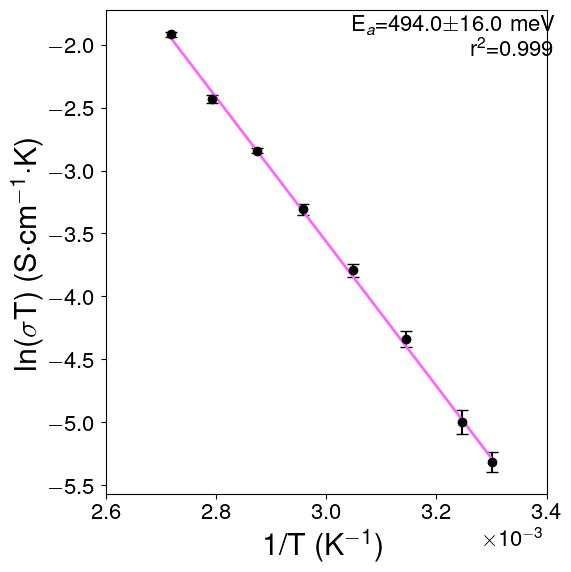

In [30]:
# Perform linear regression
#slope, intercept, r_value, p_value, std_err = linregress(finaldf['T'], finaldf['LnsigmaT'])

#set the figure size
plt.figure(figsize=(6,6))
plt.xlim(0.0026,0.0034)
blue='#3399ff'
pink='#ff66ff'

# Plotting the data and the regression line
plt.errorbar(finaldf['T'], finaldf['LnsigmaT'], yerr=finaldf['std_dev_log'],xerr=None,color='black', linestyle='none',marker='o',capsize=4)
plt.plot(x,model.predict(x),color=pink,linestyle='solid',linewidth=2)

plt.ylabel(r'ln($\sigma$T) (S$\cdot$cm$^{-1}\cdot$K)')
plt.xlabel('1/T (K$^{-1}$)')
E_mev_round=np.around(E*1000,1)
E_mev_round=''.join(map(str,E_mev_round))

CI_E_mev_round=np.around(CI_E*1000,1)

r_sq_round=np.around(r_sq,4)

showr2='yes'

if showr2=='yes':
    plotlabel=''.join(('E$_a$=',E_mev_round,r'$\pm$',str(CI_E_mev_round),' meV','\nr$^2$=',str(r_sq_round)))
else:              
    plotlabel=''.join(('\n','E$_a$=',E_mev_round,r'$\pm$',str(CI_E_mev_round), ' meV'))

plt.ticklabel_format(axis='x',style='sci',scilimits=(0,0))

plt.figtext(0.95,0.95,plotlabel ,horizontalalignment='right',verticalalignment='top',)
plt.tight_layout()

#THIS IS WHERE THE ARRHENIUS AND SUMMARY DATA WILL BE SAVED
saveloc_DIR='C:/Users/aph98/OneDrive/Documents/Mines/Research/EIS_Data/APH_1_021A'

subfolds=''

#filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), materialname)

# filter returns a generator, so we need to re-join the string
cleaned_matname = "".join(cleaned_matname)

saveloc=''.join((saveloc_DIR,subfolds))
if not os.path.isdir(saveloc):
        os.makedirs(saveloc_DIR)
plot_filename=''.join((saveloc,'/',samplename,' ',cleaned_matname,' Arrhenius_Plot.png'))
plt.savefig(plot_filename,dpi=300, bbox_inches="tight")

plt.show()



# Set the fontsize of the tick labels


# Displaying the legend
#plt.legend()

# Show the plot

# Display regression statistics
#print(f"Slope: {slope}")
#print(f"Intercept: {intercept}")
#print(f"R-squared value: {r_value**2}")
#print(f"P-value: {p_value}")

In [31]:
#Generate a pandas dataframe with all the relevant parameters from the fit

#modify samplename and materialname as appropriate
samplename='2_089_1 last 3 datasets'
materialname='Li$_6$PS$_5$CN'

slope=[float(model.coef_)]*len(finaldf)
intercept=[model.intercept_]*len(finaldf)
Ea=[float(E)]*len(finaldf)
CI_Ea=[CI_E]*len(finaldf)
samplenamez=[samplename]*len(finaldf)
materialnamez=[materialname]*len(finaldf)
r_sqs=[r_sq]*len(finaldf)
conductivityz=[conductivity]*len(finaldf)
moez=[moe]*len(finaldf)
moez_prefactor=[absolute_error]*len(finaldf)
meanz_prefactor=[prefactor]*len(finaldf)

exportdf = pd.DataFrame({
    'T':target_temperatures,
    '1/T': finaldf['T'],
    'LnsigmaT': finaldf['LnsigmaT'],
    'std_dev_ln':finaldf['std_dev_log'],
    'slope':slope,
    'intercept':intercept,
    'r_squared':r_sqs,
    'Ea':Ea,
    'CI_Ea':CI_Ea,
    'sample_name':samplenamez,
    'material_name':materialnamez,
    '30c conductivity':conductivityz,
    '30c conductivity MOE':moez,
    'Prefactor':meanz_prefactor,
    'Prefactor MOE':moez_prefactor
})

print(exportdf)



    T       1/T  LnsigmaT  std_dev_ln        slope  intercept  r_squared  \
0  30  0.003300 -5.314330    0.076242 -5732.340841  13.631372   0.999001   
1  35  0.003247 -5.001021    0.095346 -5732.340841  13.631372   0.999001   
2  45  0.003145 -4.336953    0.062336 -5732.340841  13.631372   0.999001   
3  55  0.003049 -3.792769    0.051359 -5732.340841  13.631372   0.999001   
4  65  0.002959 -3.308036    0.042595 -5732.340841  13.631372   0.999001   
5  75  0.002874 -2.841945    0.018974 -5732.340841  13.631372   0.999001   
6  85  0.002793 -2.433439    0.029553 -5732.340841  13.631372   0.999001   
7  95  0.002717 -1.918117    0.018334 -5732.340841  13.631372   0.999001   

         Ea     CI_Ea              sample_name   material_name  \
0  0.493975  0.016018  2_089_1 last 3 datasets  Li$_6$PS$_5$CN   
1  0.493975  0.016018  2_089_1 last 3 datasets  Li$_6$PS$_5$CN   
2  0.493975  0.016018  2_089_1 last 3 datasets  Li$_6$PS$_5$CN   
3  0.493975  0.016018  2_089_1 last 3 datasets  Li$

C:\Users\aph98\AppData\Local\Temp\ipykernel_23612\2254066798.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  slope=[float(model.coef_)]*len(finaldf)
C:\Users\aph98\AppData\Local\Temp\ipykernel_23612\2254066798.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ea=[float(E)]*len(finaldf)


In [32]:
#save the dataframe generated in the previous cell

#filter non-alphanumeric and space characters from the material name so that it's easier to deal with from a file management perspective
cleaned_matname = filter(lambda x: x.isalnum() or x.isspace(), materialname)

# filter returns a generator, so we need to re-join the string
cleaned_matname = "".join(cleaned_matname)

#THIS IS WHERE THE ARRHENIUS AND SUMMARY DATA WILL BE SAVED
saveloc_DIR='C:/Users/aph98/OneDrive/Documents/Mines/Research/EIS_Data/APH_1_021A'

subfolds=''

saveloc=''.join((saveloc_DIR,subfolds))

filename=''.join((saveloc,'/',samplename,' ',cleaned_matname,' Arrhenius and Summary Plot.csv'))
plot_filename=''.join((saveloc,'/',samplename,' ',cleaned_matname,' Arrhenius_Plot.png'))
readytosave=True

if readytosave==True:
    if not os.path.isdir(saveloc):
        os.makedirs(saveloc_DIR)
    exportdf.to_csv(filename)




,$T$ ($^\circ$C),&,Replicate Scan,&,R$_0$ ($\Omega$),&,$R_1$ ($\Omega$),&,$\sigma$ (S cm$^{-1}$),&,...,$Q_1$(S/s$^n$),&,$C_1$ (F),&,$\tau_{1}$ (Hz),&,$n_2$,&,$Q_2$(S/s$^n$),\\
0,30,&,1,&,1.54e-02,&,4.97e+04,&,1.59e-05,&,...,7.47e-12,&,3.92e-12,&,8.17e+05,&,0.86,&,8.78e-08,\\
1,30,&,2,&,1.30e-02,&,4.84e+04,&,1.63e-05,&,...,7.75e-12,&,3.93e-12,&,8.36e+05,&,0.84,&,9.29e-08,\\
2,30,&,3,&,2.31e-02,&,4.81e+04,&,1.65e-05,&,...,9.41e-12,&,3.90e-12,&,8.50e+05,&,0.84,&,9.65e-08,\\
3,35,&,1,&,8.81e-02,&,3.56e+04,&,2.22e-05,&,...,6.94e-12,&,3.82e-12,&,1.17e+06,&,0.81,&,1.32e-07,\\
4,35,&,2,&,7.14e-02,&,3.68e+04,&,2.15e-05,&,...,1.22e-11,&,4.04e-12,&,1.07e+06,&,0.81,&,1.35e-07,\\
5,35,&,3,&,5.09e-02,&,3.55e+04,&,2.23e-05,&,...,5.92e-12,&,3.82e-12,&,1.17e+06,&,0.80,&,1.43e-07,\\
6,35,&,4,&,9.99e-01,&,3.70e+04,&,2.14e-05,&,...,6.68e-12,&,3.77e-12,&,1.14e+06,&,0.82,&,1.33e-07,\\
7,45,&,1,&,1.01e-01,&,1.97e+04,&,4.01e-05,&,...,1.30e-11,&,4.23e-12,&,1.91e+06,&,0.79,&,2.12e-07,\\
8,45,&,2,&,8.67e-01,&,1.93e+04,&,4.09e-05,&,...,6.78e-12,&,4.24e-12,&,1.94e+06,&,0.78,&,2.20e-07,\\
9,45,&,3,&,1.85e-01,&,1.92e+04,&,4.12e-05,&,...,6.22e-12,&,4.18e-12,&,1.98e+06,&,0.78,&,2.21e-07,\\


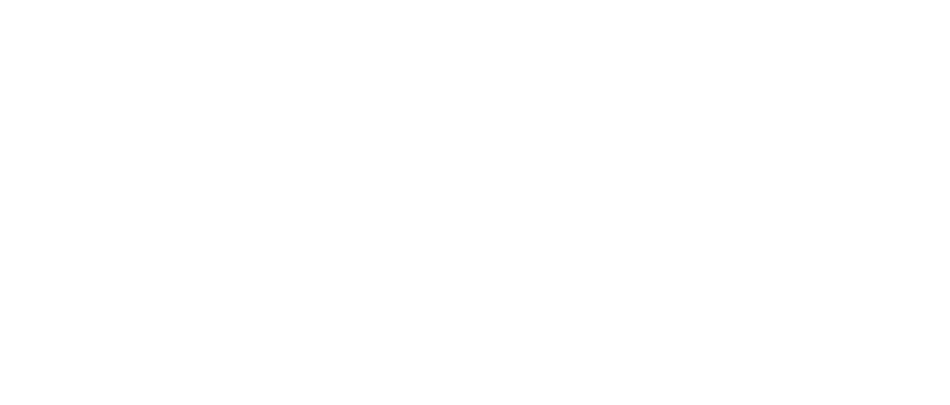

In [36]:
#This cell generates a table of echem data that can be pasted into latex!

#leading resistor
R1={}
#parallel Resistor
R2={}
#parallel constant phase element
Q2={}
n2={}
#tailing constant phase element
Q3={}
n3={}

capacitance={}
char_freq={}

for key, exp_instance in all_experiments.items():
    R1[key]=float(exp_instance.fit_Rs[0])
    R2[key]=float(exp_instance.fit_R1[0])
    n2[key]=float(exp_instance.fit_n1[0])
    Q2[key]=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0])
    capacitance[key]=(((Q2[key]*R2[key])**(1/n2[key]))/R2[key])
    char_freq[key]=float(exp_instance.fit_fs1[0])
    n3[key]=float(exp_instance.fit_n[0])
    Q3[key]=float(exp_instance.fit_Q[0])
    
    
#print(R2)
# Create a mapping from old keys to new keys

new_keys_mapping = {}
counters = {}

for key in R2.keys():
    if key[0] not in counters:
        counters[key[0]] = 1
    new_keys_mapping[key] = (key[0], counters[key[0]])
    counters[key[0]] += 1

# Function to reindex dictionaries based on new_keys_mapping
def reindex_dict(original_dict):
    new_dict = {}
    for old_key, value in original_dict.items():
        new_key = new_keys_mapping[old_key]
        new_dict[new_key] = value
    return new_dict

# Reindex all dictionaries
R1_new = reindex_dict(R1)
R2_new = reindex_dict(R2)
n2_new = reindex_dict(n2)
Q2_new = reindex_dict(Q2)
n3_new = reindex_dict(n3)
Q3_new = reindex_dict(Q3)
sigma_new=reindex_dict(sigma)
capacitance_new=reindex_dict(capacitance)
char_freq_new=reindex_dict(char_freq)
reindexed_experiments=reindex_dict(all_experiments)

#print(reindexed_experiments)
#print(R2_new)

# Combine reindexed dictionaries into a single DataFrame
refinedparams = {
    r'$T$ ($^\circ$C)': [key[0] for key in R1_new.keys()],
    'Replicate Scan': [key[1] for key in R1_new.keys()],
    r'R$_0$ ($\Omega$)': list(R1_new.values()),
    r'$R_1$ ($\Omega$)': list(R2_new.values()),
    r'$\sigma$ (S cm$^{-1}$)':list(sigma_new.values()),
    r'$n_1$': list(n2_new.values()),
    r'$Q_1$(S/s$^n$)': list(Q2_new.values()),
    r'$C_1$ (F)': list(capacitance_new.values()),
    r'$\tau_{1}$ (Hz)': list(char_freq_new.values()),
    r'$n_2$': list(n3_new.values()),
    r'$Q_2$(S/s$^n$)': list(Q3_new.values())
    
}

refinedparams = pd.DataFrame(refinedparams)


# Create a figure and add the DataFrame as a table
fig, ax = plt.subplots(figsize=(12, 5))  # Set the figure size as needed
ax.axis('off')  # Hide the axes

#roundedrefinedparams=refinedparams.round(2)
def scientific_notation(x):
    return f"{x:.2e}"


columns_to_sci = [r'R$_0$ ($\Omega$)',r'$R_1$ ($\Omega$)',r'$Q_1$(S/s$^n$)',r'$C_1$ (F)',r'$Q_2$(S/s$^n$)',r'$\sigma$ (S cm$^{-1}$)',r'$\tau_{1}$ (Hz)']
refinedparams[columns_to_sci] = refinedparams[columns_to_sci].applymap(scientific_notation)
columns_to_round=[r'$n_1$',r'$n_2$']
refinedparams[columns_to_round]=refinedparams[columns_to_round].round(2)
#Add '&' columns and '\' at the end of each row
for col in refinedparams.columns[:-1]:
    refinedparams.insert(refinedparams.columns.get_loc(col)+1, '&', '&',allow_duplicates=True)

# Add the '\\' column at the end
refinedparams['\\\\'] = '\\\\'
display(refinedparams)
# Add the table to the plot
#table = ax.table(cellText=refinedparams.values, colLabels=refinedparams.columns, cellLoc='center', loc='center')
#ax.set_title(materialname)
# Initialize a list to store formatted rows
formatted_rows = []

# Loop through each row in the DataFrame
#for _, row in refinedparams.iterrows():
    # Join each row value with '&', then add '\\' at the end
    #formatted_row = ' & '.join(row.astype(str)) + r' \\'
    #formatted_rows.append(formatted_row)

# Combine all rows into the final table string
#latex_table = '\n'.join(formatted_rows)

# Print the LaTeX table string
#print(latex_table)
# Style the table
#table.auto_set_font_size(False)
#table.autofit=True
#table.set_fontsize(10)
#table.scale(1.2, 1.2)  # Adjust the scaling as needed

#plt.show()

#this is the repository for all our temp dependent nyquists!
params_saveloc_DIR='C:/Users/aph98/OneDrive/Documents/Mines/Research/EIS_Data/APH_1_021A'
#this will be the folder into which we whang all of the dataframes, named based on the sample and material name
params_filename=f"{samplename}_{cleaned_matname}_refinedparameters.csv"


#here we save all of our dataframes! don't want to miss out on any yummy data, so we save it all
#the save format is temp_30_replicate_1_1-107A Pellet 2_SSM Li6PS5Cl, obviously different if your materials aren't exactly like mine
readytosave=True
if readytosave==True:
    if not os.path.isdir(params_saveloc_DIR):
        os.makedirs(params_saveloc_DIR)
    refinedparams.to_csv(f"{params_saveloc_DIR}/{params_filename}")


In [38]:
#in this cell, we generate simulated data for each nyquist plot so as to be able to export experimental and modeled values
#for temperature dependent nyquist plots

#generates a frequency range for any simulations
f_range = freq_gen(f_start=(2*10**6), f_stop=0.2, pts_decade=10)
print(f_range[0][:4]) #First 5 points in the freq. array
print()
print(f_range[1][:4]) #First 5 points in the angular freq. array


#This chunk of code generates a simulated dataset using the parameters from the initial modelling above
sim={}

# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in reindexed_experiments.items():
        sim_temp= cir_RsRQQ(w=f_range[1], Rs=float(exp_instance.fit_Rs[0]), R1=float(exp_instance.fit_R1[0]), n1=float(exp_instance.fit_n1[0]), Q1=((1/(2*3.14159*float(exp_instance.fit_fs1[0])))**float(exp_instance.fit_n1[0]))/float(exp_instance.fit_R1[0]), n=float(exp_instance.fit_n[0]), Q=float(exp_instance.fit_Q[0]))
        sim[key]=sim_temp
        

[2000000.         1583363.8318526  1253520.51200948  992389.52060058]

[12566370.61435917  9948568.36421585  7876101.66330618  6235367.25483656]


In [39]:

    
#here we make a bunch of dataframes with all of the info we need for nyquist plots
nyquistdf={}
# Iterate through the outer dictionary (temperature-wise experiments)
for key, exp_instance in reindexed_experiments.items():
        min_length = min(len(exp_instance.df_raw.re), len(exp_instance.df_raw.im), len(sim[key].real), len(sim[key].imag),len(exp_instance.df_raw.f))
        key_temp=[key]*min_length
        samplenamez=[samplename]*min_length
        materialnamez=[materialname]*min_length
        diameterz=[diameter]*min_length
        heightz=[height]*min_length
        # Truncate arrays to the minimum length
        truncated_re = exp_instance.df_raw.re[:min_length]
        truncated_im = exp_instance.df_raw.im[:min_length]
        truncated_f= exp_instance.df_raw.f[:min_length]
        truncated_fit_real = sim[key].real[:min_length]
        truncated_fit_imag = -sim[key].imag[:min_length]
        
        # Create DataFrame with truncated arrays
        nyquistdf[key] = pd.DataFrame({
            'Frequency':truncated_f,
            'Z real': truncated_re,
            'Z imag': truncated_im,
            'Fit real': truncated_fit_real,
            'Fit imag': truncated_fit_imag,
            'Dataset':key_temp,
            'sample_name':samplenamez,
            'material_name':materialnamez,
            'height':heightz,
            'diameter':diameterz
        })
print(nyquistdf)
#this is the repository for all our temp dependent nyquists!
nyquist_saveloc_DIR='/Users/shelbygalinat/Documents/Documents/School/Grad_School/Research/EIS/SLG_2_089_Li6PS5CN/SLG_2_089_Li6PS5CN_1/T_dep_Nyquists'
#this will be the folder into which we whang all of the dataframes, named based on the sample and material name
save_location=''.join((nyquist_saveloc_DIR,'/',samplename,' ',cleaned_matname))


#here we save all of our dataframes! don't want to miss out on any yummy data, so we save it all
#the save format is temp_30_replicate_1_1-107A Pellet 2_SSM Li6PS5Cl, obviously different if your materials aren't exactly like mine
readytosave=True
if readytosave==True:
    for key,df in nyquistdf.items():
        filename=f"temp_{key[0]}_replicate_{key[1]}_{samplename}_{cleaned_matname}.csv"
        if not os.path.isdir(save_location):
            os.makedirs(save_location)
        df.to_csv(f"{save_location}/{filename}")


{(30, 1):        Frequency       Z real      Z imag      Fit real      Fit imag  \
0   2.000039e+06     5844.646    18630.87  8.357489e+03  1.703221e+04   
1   1.588711e+06    10206.770    21839.97  1.163684e+04  1.948346e+04   
2   1.261992e+06    16787.430    22322.11  1.574917e+04  2.155745e+04   
3   1.002539e+06    19448.300    24403.97  2.055623e+04  2.290970e+04   
4   7.962891e+05    27116.990    21775.85  2.573083e+04  2.327053e+04   
..           ...          ...         ...           ...           ...   
65  6.334459e-01   863946.400  3489838.00  9.960140e+05  4.104834e+06   
66  5.029507e-01  1060553.000  4240047.00  1.205418e+06  5.013156e+06   
67  3.999573e-01  1301325.000  5145430.00  1.461159e+06  6.122473e+06   
68  3.175813e-01  1600183.000  6247529.00  1.773491e+06  7.477260e+06   
69  2.520161e-01  1969551.000  7583452.00  2.154936e+06  9.131837e+06   

    Dataset              sample_name   material_name  height  diameter  
0   (30, 1)  2_089_1 last 3 datasets  Li

PermissionError: [WinError 5] Access is denied: '/Users/shelbygalinat'